In [5]:
import hvsrpy
import numpy as np
import pandas as pd

from obspy.clients.fdsn import Client
from obspy.core import read

import time
from scipy import stats
from matplotlib import pyplot as plt

In [35]:
import glob
import sys

In [6]:
"""TIME DOMAIN SETTING"""

# Input file name (may be a relative or full path).

# Window length in seconds. In general low frequency peaks require longer window lengths.
# See the SESAME guidelines for specific window length recommendations.
windowlength = 60

# Boolean to control whether Butterworth filter is applied. 
# Geopsy does not apply a bandpass filter.
filter_bool = False        
# Low-cut frequency for bandpass filter.
filter_flow = 0.1                   
# High-cut frequency for bandpass filter.
filter_fhigh = 30                   
# Filter order.
filter_order = 5

# Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
width = 0.1


"""FREQUENCY DOMAIN SETTING"""

# Konno and Ohmachi smoothing constant. 40 is recommended.
bandwidth = 40

# Minimum frequency after resampling
resample_fmin = 0.1  
# Maximum frequency after resampling
resample_fmax = 50
# Number of frequencies after resampling
resample_fnum = 200
# Type of resampling {'log', 'linear'}
resample_type = 'log'

# Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
peak_f_lower = None
peak_f_upper = None

"""HVSR Settings"""

# Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
# Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
method = "geometric-mean"
# If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
azimuth = 0

# Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
# Geopsy does not offer this functionality.
rejection_bool = True
# Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
n = 2
# Maximum number of iterations to perform for rejection -> 50 is recommended.
max_iterations = 50

# Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
distribution_f0 = "lognormal"
# Distribution of mean curve {"lognormal", "normal"}. Geopsy default "lognormal" -> "lognormal" is recommended.
distribution_mc = "lognormal"

In [12]:
def get_hvsr(filename): 
    """TIME DOMAIN SETTING"""

    # Input file name (may be a relative or full path).

    # Window length in seconds. In general low frequency peaks require longer window lengths.
    # See the SESAME guidelines for specific window length recommendations.
    '''windowlength default is 60'''
    
    windowlength = 45

    # Boolean to control whether Butterworth filter is applied. 
    # Geopsy does not apply a bandpass filter.
    filter_bool = False        
    # Low-cut frequency for bandpass filter.
    filter_flow = 0.1                   
    # High-cut frequency for bandpass filter.
    filter_fhigh = 30                   
    # Filter order.
    filter_order = 5

    # Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
    width = 0.1


    """FREQUENCY DOMAIN SETTING"""

    # Konno and Ohmachi smoothing constant. 40 is recommended.
    bandwidth = 40

    # Minimum frequency after resampling
    resample_fmin = 0.1  
    # Maximum frequency after resampling
    resample_fmax = 50
    # Number of frequencies after resampling
    resample_fnum = 200
    # Type of resampling {'log', 'linear'}
    resample_type = 'log'

    # Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
    peak_f_lower = None
    peak_f_upper = None

    """HVSR Settings"""

    # Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
    # Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
    method = "geometric-mean"
    # If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
    azimuth = 0

    # Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
    # Geopsy does not offer this functionality.
    rejection_bool = True
    # Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
    n = 2
    # Maximum number of iterations to perform for rejection -> 50 is recommended.
    max_iterations = 50

    # Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
    distribution_f0 = "lognormal"
    # Distribution of mean curve {"lognormal", "normal"}. Geopsy default "lognormal" -> "lognormal" is recommended.
    distribution_mc = "lognormal"



    ymin, ymax = 0, 10
    fig = plt.figure(figsize=(6,6), dpi=150)
    gs = fig.add_gridspec(nrows=6,ncols=6)

    ax0 = fig.add_subplot(gs[0:2, 0:3])
    ax1 = fig.add_subplot(gs[2:4, 0:3])
    ax2 = fig.add_subplot(gs[4:6, 0:3])

    if rejection_bool:
        ax3 = fig.add_subplot(gs[0:3, 3:6])
        ax4 = fig.add_subplot(gs[3:6, 3:6])
    else:
        ax3 = fig.add_subplot(gs[0:3, 3:6])
        ax4 = False

    start = time.time()
    sensor = hvsrpy.Sensor3c.from_mseed(filename)
    bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}
    resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}
    hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method, f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)
    end = time.time()
    print(f"Elapsed Time: {str(end-start)[0:4]} seconds")

    individual_width = 0.3
    median_width = 1.3
    for ax, title in zip([ax3, ax4], ["Before Rejection", "After Rejection"]):
        # Rejected Windows
        if title=="After Rejection":
            if len(hv.rejected_window_indices):
                label = "Rejected"
                for amp in hv.amp[hv.rejected_window_indices]:
                    ax.plot(hv.frq, amp, color='#00ffff', linewidth=individual_width, zorder=2, label=label)
                    label=None

        # Accepted Windows
        label="Accepted"
        for amp in hv.amp[hv.valid_window_indices]:
            ax.plot(hv.frq, amp, color='#888888', linewidth=individual_width,
                    label = label if title=="Before Rejection" else "")
            label=None

        # Window Peaks
        ax.plot(hv.peak_frq, hv.peak_amp, linestyle="", zorder=2,
                marker='o', markersize=2.5, markerfacecolor="#ffffff", markeredgewidth=0.5, markeredgecolor='k',
                label="" if title=="Before Rejection" and rejection_bool else r"$f_{0,i}$")

        # Peak Mean Curve
        ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=4,
                marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
                label = "" if title=="Before Rejection" and rejection_bool else r"$f_{0,mc}$")

        # Mean Curve
        label = r"$LM_{curve}$" if distribution_mc=="lognormal" else "Mean"   
        ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', linewidth=median_width,
                label="" if title=="Before Rejection" and rejection_bool else label)

        # Mean +/- Curve
        label = r"$LM_{curve}$"+" ± 1 STD" if distribution_mc=="lognormal" else "Mean ± 1 STD"
        ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc),
                color='k', linestyle='--', linewidth=median_width, zorder=3,
                label = "" if title=="Before Rejection" and rejection_bool else label)
        ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc),
                color='k', linestyle='--', linewidth=median_width, zorder=3)

        # f0 +/- STD
        if ymin is not None and ymax is not None:
            ax.set_ylim((ymin, ymax))
        label = r"$LM_{f0}$"+" ± 1 STD" if distribution_f0=="lognormal" else "Mean f0 ± 1 STD"    
        _ymin, _ymax = ax.get_ylim()
        ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [_ymin, _ymax], linestyle="-.", color="#000000")
        ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [_ymin, _ymax, _ymax, _ymin], 
                color = "#ff8080",
                label="" if title=="Before Rejection" and rejection_bool else label)
        ax.set_ylim((_ymin, _ymax))

        ax.set_xscale('log')
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("HVSR Amplitude")
        if rejection_bool:
            if title=="Before Rejection":
                print("\nStatistics before rejection:")
                hv.print_stats(distribution_f0)
                c_iter = hv.reject_windows(n, max_iterations=max_iterations, 
                                           distribution_f0=distribution_f0, distribution_mc=distribution_mc)
            elif title=="After Rejection":
                fig.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.51, 0), columnspacing=2)

                print("\nAnalysis summary:")  
                display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows", "Number of iterations to convergence", "No. of rejected windows"], 
                        data=[f"{windowlength}s", str(sensor.ns.nseries), f"{c_iter} of {max_iterations} allowed", str(sum(hv.rejected_window_indices))]))            
                print("\nStatistics after rejection:")
                hv.print_stats(distribution_f0)
        else:
            display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows"], 
                             data=[f"{windowlength}s", str(sensor.ns.nseries)]))
            hv.print_stats(distribution_f0)
            fig.legend(loc="upper center", bbox_to_anchor=(0.77, 0.4))
            break
        ax.set_title(title)

    norm_factor = sensor.normalization_factor
    for ax, timerecord, name in zip([ax0,ax1,ax2], [sensor.ns, sensor.ew, sensor.vt], ["NS", "EW", "VT"]):
        ctime = timerecord.time
        amp = timerecord.amp/norm_factor
        ax.plot(ctime.T, amp.T, linewidth=0.2, color='#888888')
        ax.set_title(f"Time Records ({name})")
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_xlim(0, windowlength*timerecord.nseries)
        ax.set_ylim(-1, 1)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Normalized Amplitude')
        ax.plot(ctime[hv.rejected_window_indices].T, amp[hv.rejected_window_indices].T, linewidth=0.2, color="cyan")

    if rejection_bool:
        axs = [ax0, ax3, ax1, ax4, ax2]
    else:
        axs = [ax0, ax3, ax1, ax2]

    for ax, letter in zip(axs, list("abcde")):    
        ax.text(0.97, 0.97, f"({letter})", ha="right", va="top", transform=ax.transAxes, fontsize=12)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)


    fig.tight_layout(h_pad=1, w_pad=2, rect=(0,0.08,1,1))
    plt.show()

In [31]:
files = [ea for ea in glob.glob('*.mseed')]

In [32]:
files

['00.mseed',
 '01.mseed',
 '010.mseed',
 '011.mseed',
 '012.mseed',
 '013.mseed',
 '014.mseed',
 '015.mseed',
 '016.mseed',
 '017.mseed',
 '018.mseed',
 '019.mseed',
 '02.mseed',
 '020.mseed',
 '021.mseed',
 '022.mseed',
 '023.mseed',
 '024.mseed',
 '025.mseed',
 '026.mseed',
 '027.mseed',
 '028.mseed',
 '029.mseed',
 '03.mseed',
 '030.mseed',
 '031.mseed',
 '032.mseed',
 '033.mseed',
 '034.mseed',
 '035.mseed',
 '036.mseed',
 '037.mseed',
 '038.mseed',
 '039.mseed',
 '04.mseed',
 '040.mseed',
 '041.mseed',
 '042.mseed',
 '043.mseed',
 '044.mseed',
 '045.mseed',
 '046.mseed',
 '047.mseed',
 '048.mseed',
 '049.mseed',
 '05.mseed',
 '050.mseed',
 '051.mseed',
 '052.mseed',
 '053.mseed',
 '054.mseed',
 '055.mseed',
 '056.mseed',
 '057.mseed',
 '058.mseed',
 '059.mseed',
 '06.mseed',
 '07.mseed',
 '08.mseed',
 '09.mseed']

Elapsed Time: 0.09 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.47                          1.32
Fundamental Site Period, T0                 2.13                          1.32


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  2 of 50 allowed
No. of rejected windows                            2


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.40                          1.17
Fundamental Site Period, T0                 2.47                          1.17

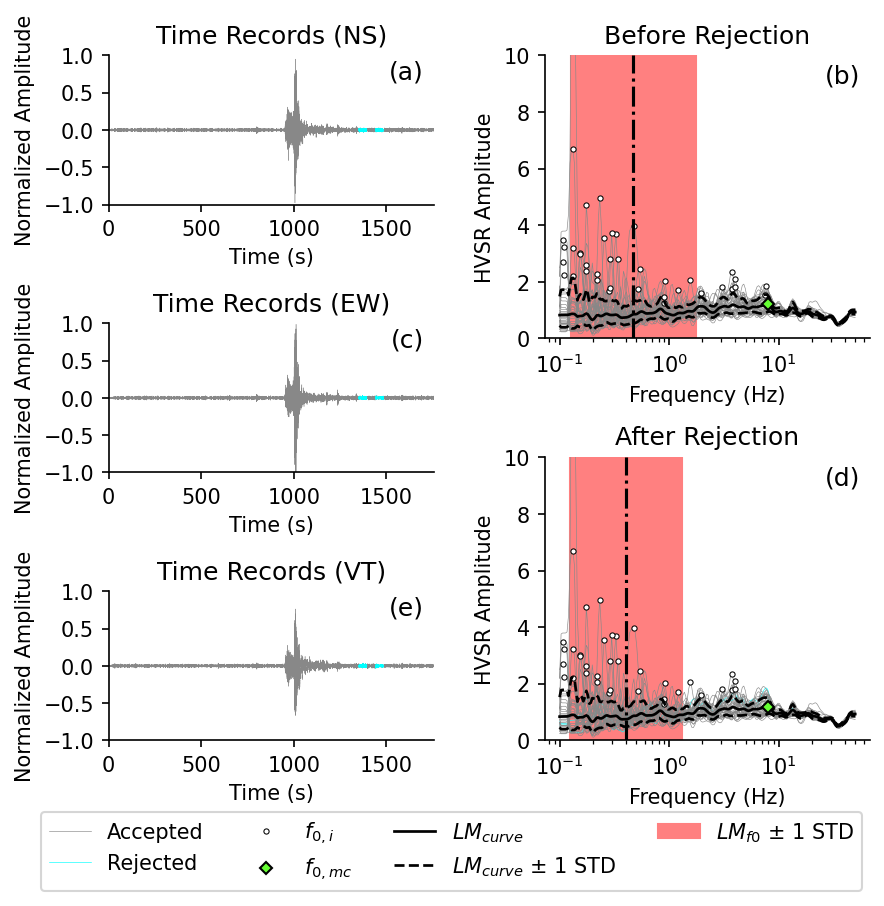

Elapsed Time: 0.10 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.25                           0.7
Fundamental Site Period, T0                 3.98                           0.7


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.25                           0.7
Fundamental Site Period, T0                 3.98                           0.7

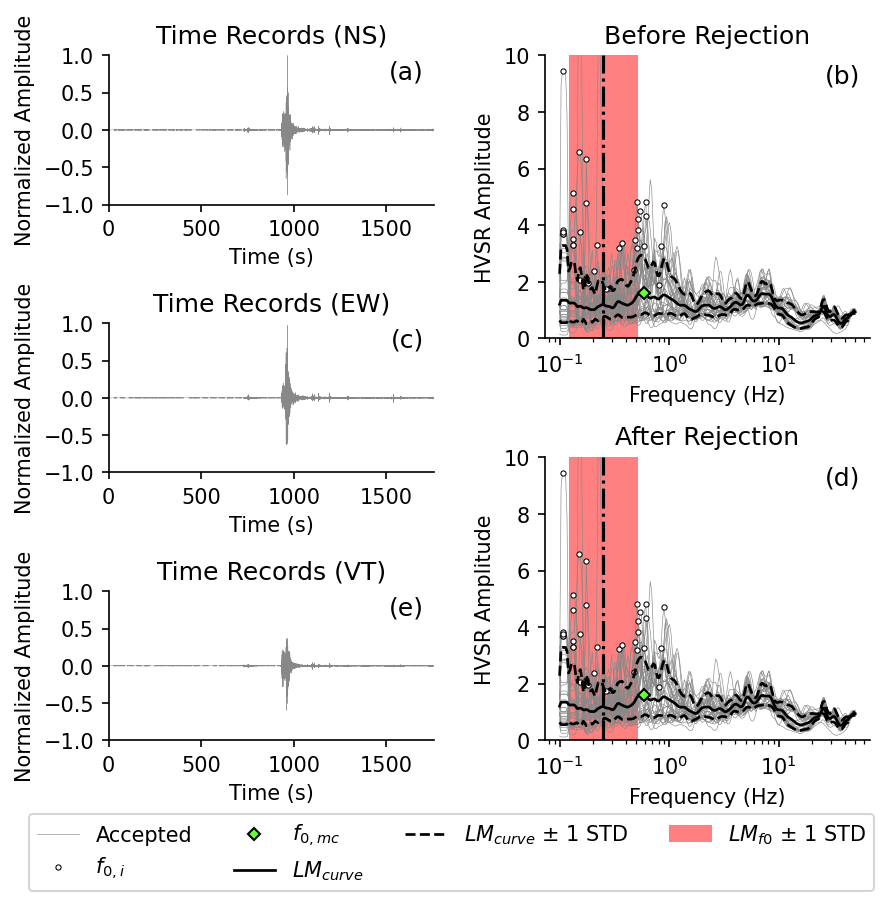

Elapsed Time: 0.11 seconds
(<class 'TypeError'>, TypeError('only size-1 arrays can be converted to Python scalars'), <traceback object at 0x000001E48D6EB140>)
Elapsed Time: 0.13 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.23                          0.81
Fundamental Site Period, T0                 4.44                          0.81


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  8 of 50 allowed
No. of rejected windows                           10


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.16                          0.25
Fundamental Site Period, T0                 6.23                          0.25

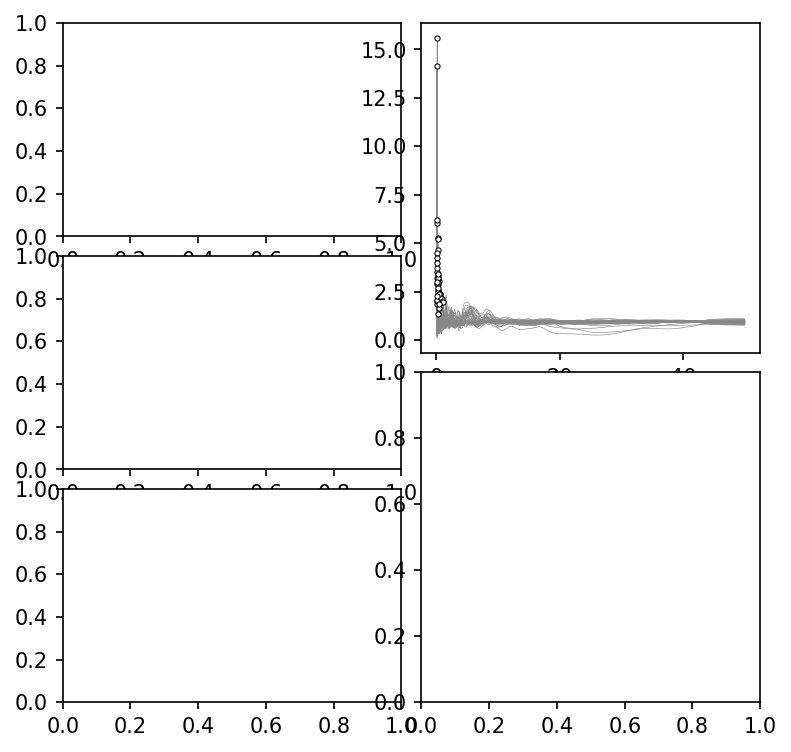

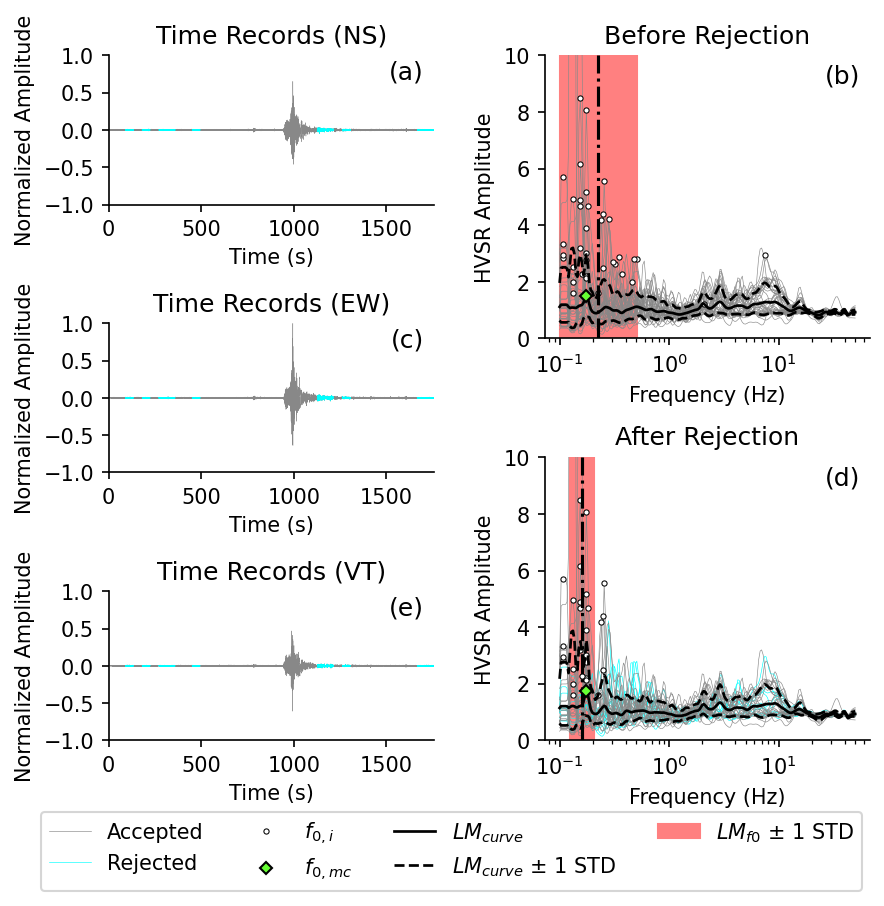

Elapsed Time: 0.11 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.93                          1.57
Fundamental Site Period, T0                 1.08                          1.57


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  2 of 50 allowed
No. of rejected windows                            2


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.76                          1.36
Fundamental Site Period, T0                 1.31                          1.36

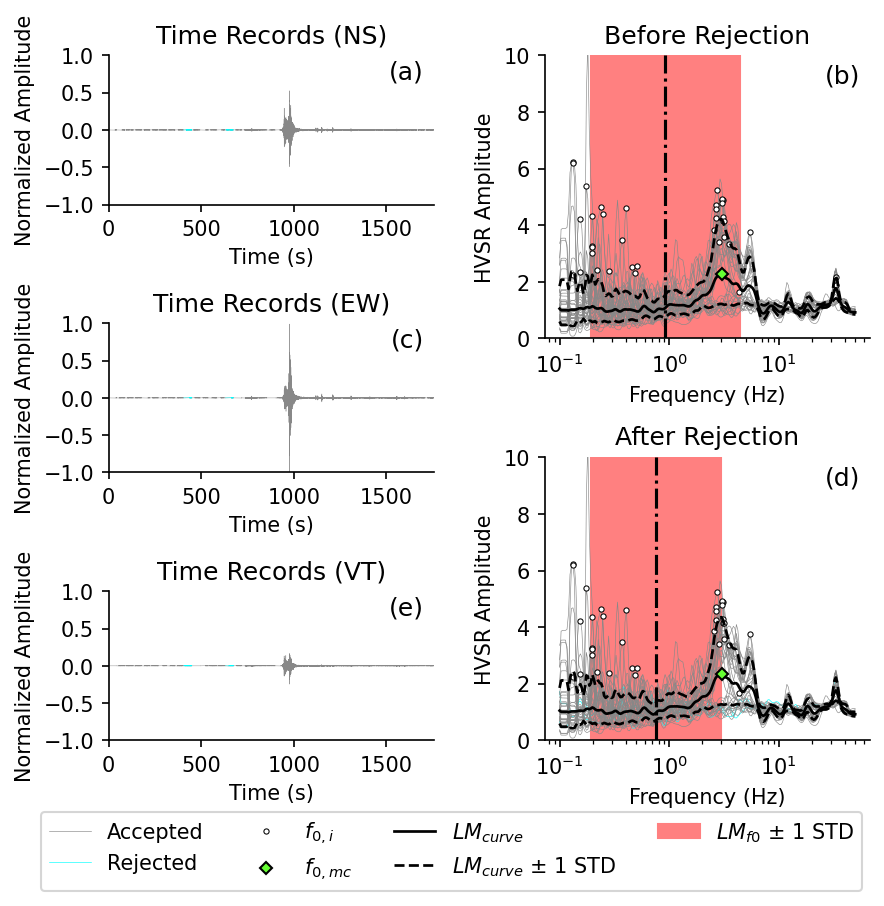

Elapsed Time: 0.12 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.77                          2.11
Fundamental Site Period, T0                 0.36                          2.11


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.77                          2.11
Fundamental Site Period, T0                 0.36                          2.11

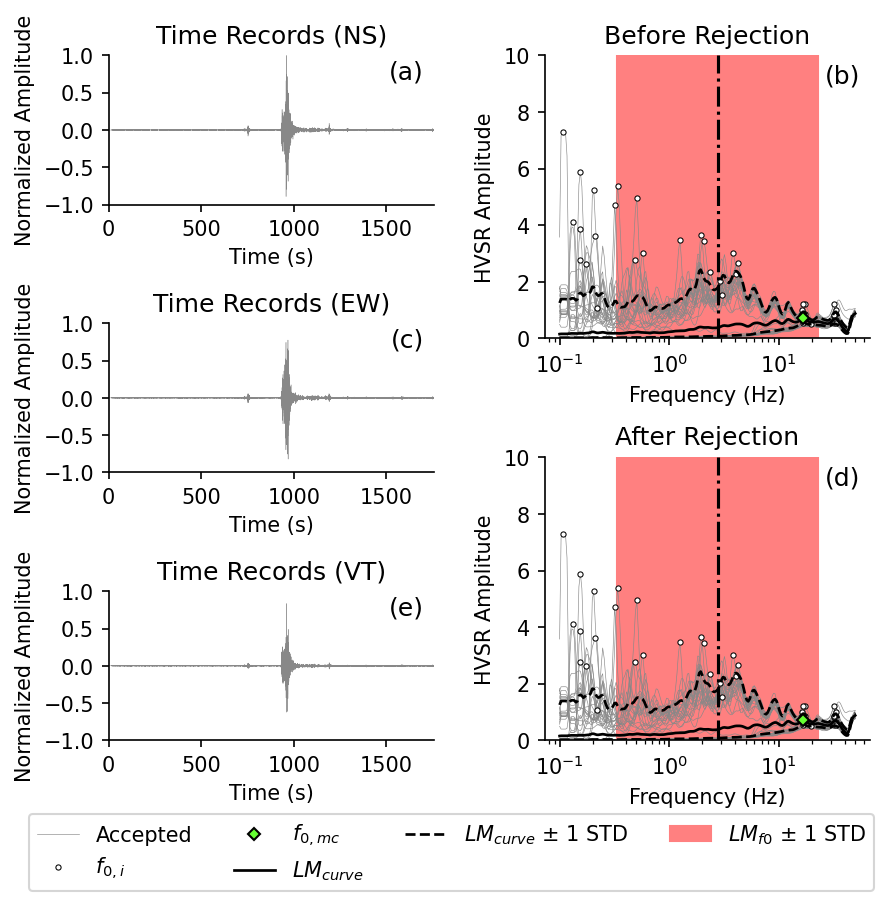

(<class 'ValueError'>, ValueError('Provided 6 traces, but must only provide 3.'), <traceback object at 0x000001E489730900>)
Elapsed Time: 0.13 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.48                          1.62
Fundamental Site Period, T0                 2.10                          1.62


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  4 of 50 allowed
No. of rejected windows                            7


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.24                          0.63
Fundamental Site Period, T0                 4.09                          0.63

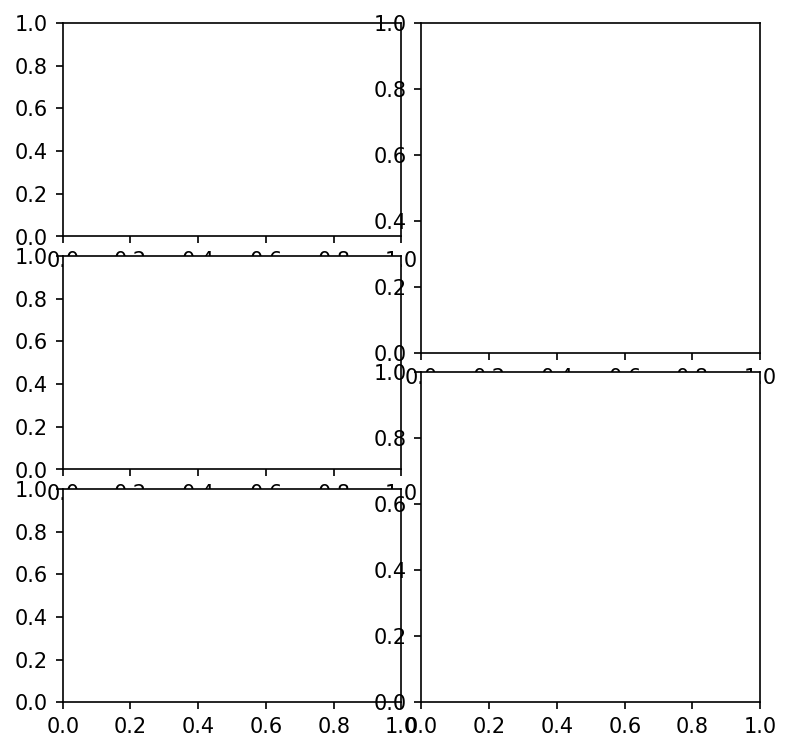

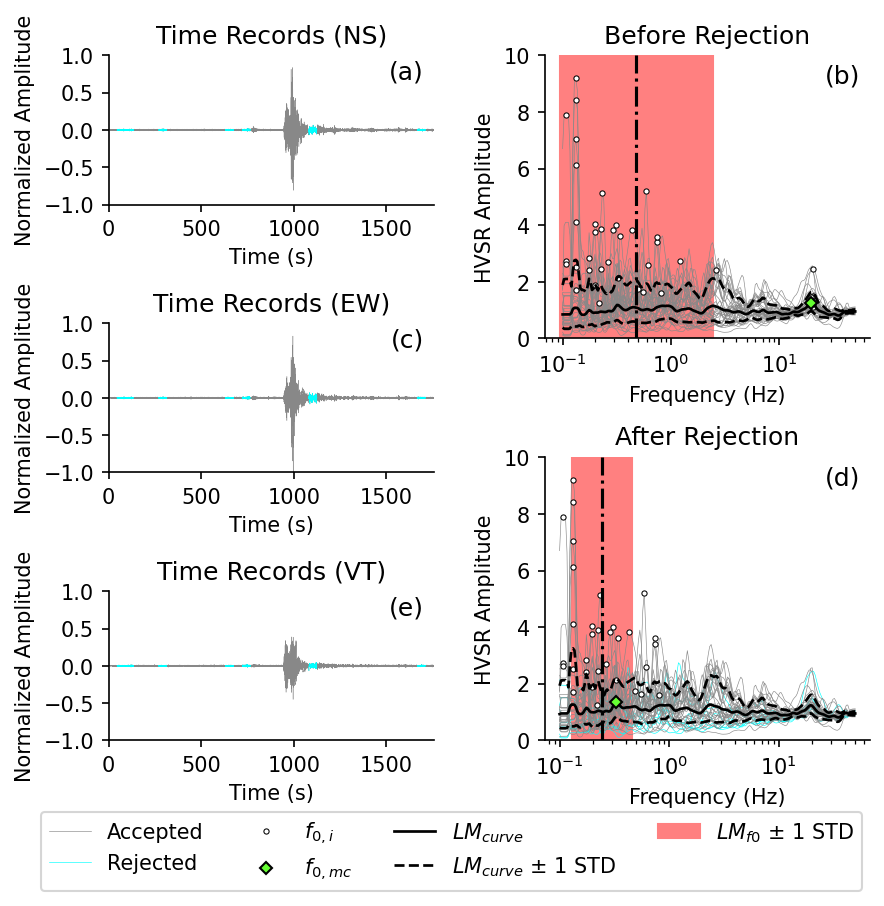

Elapsed Time: 0.15 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.34                          0.79
Fundamental Site Period, T0                 2.95                          0.79


Analysis summary:


Window length                                    45s
No. of windows                                    25
Number of iterations to convergence  3 of 50 allowed
No. of rejected windows                            2


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.29                          0.59
Fundamental Site Period, T0                 3.45                          0.59

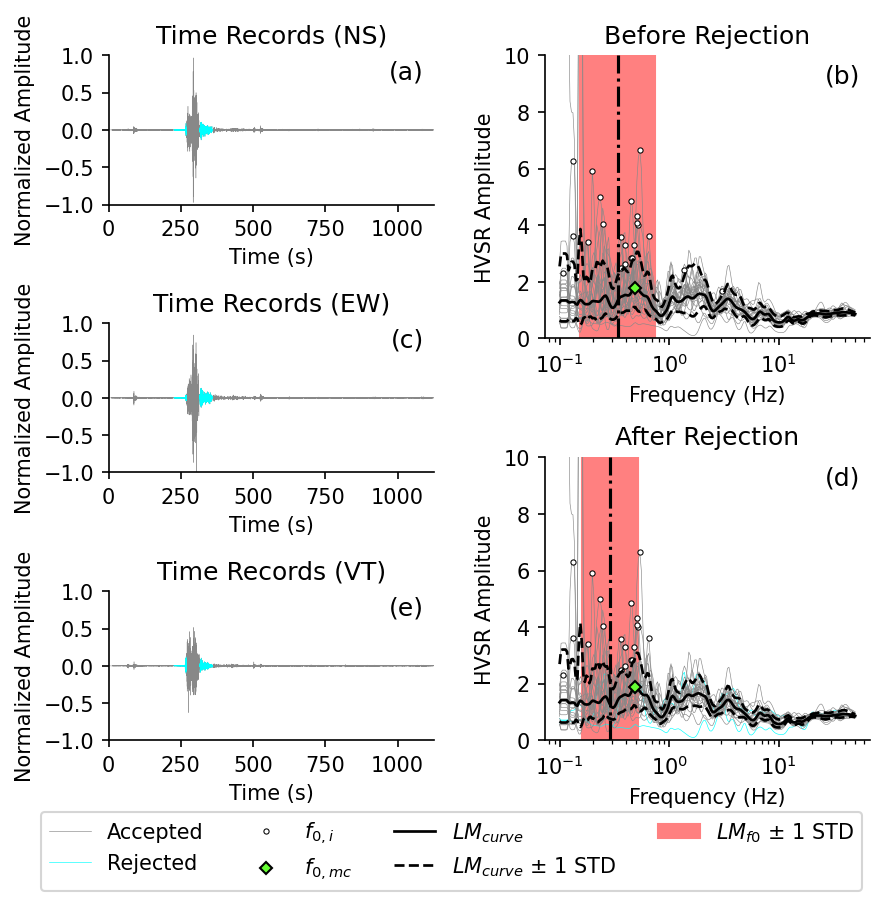

(<class 'ValueError'>, ValueError('Components are different length: ns=226887 ew=226789 vt=226687 '), <traceback object at 0x000001E48980F4C0>)
(<class 'ValueError'>, ValueError('Components are different length: ns=226785 ew=226736 vt=226639 '), <traceback object at 0x000001E499708CC0>)
(<class 'ValueError'>, ValueError('Components are different length: ns=224896 ew=224895 vt=224923 '), <traceback object at 0x000001E48BCB8380>)
Elapsed Time: 0.13 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.40                          0.93
Fundamental Site Period, T0                 2.49                          0.93


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  4 of 50 allowed
No. of rejected windows                            5


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.31                          0.67
Fundamental Site Period, T0                 3.22                          0.67

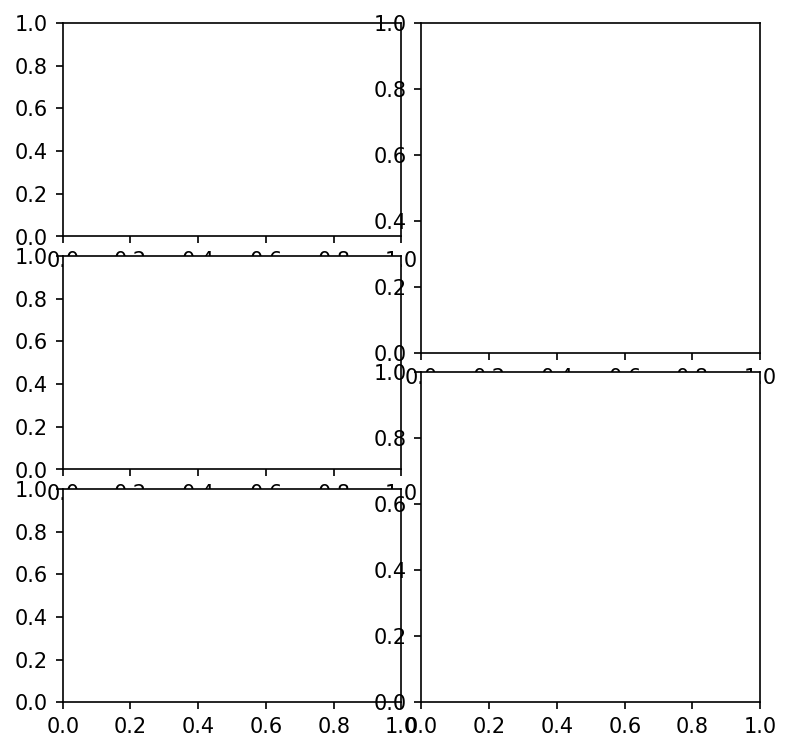

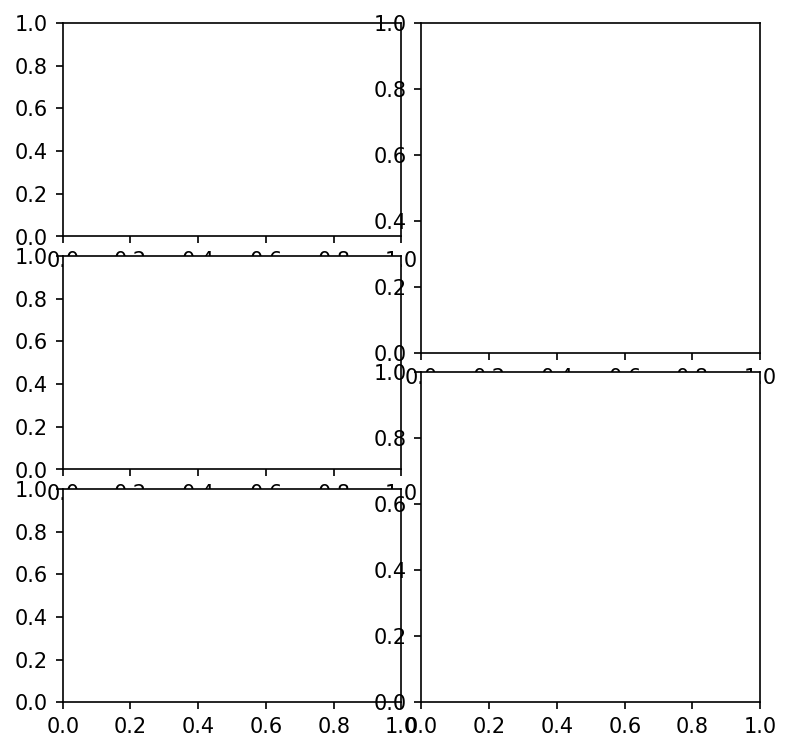

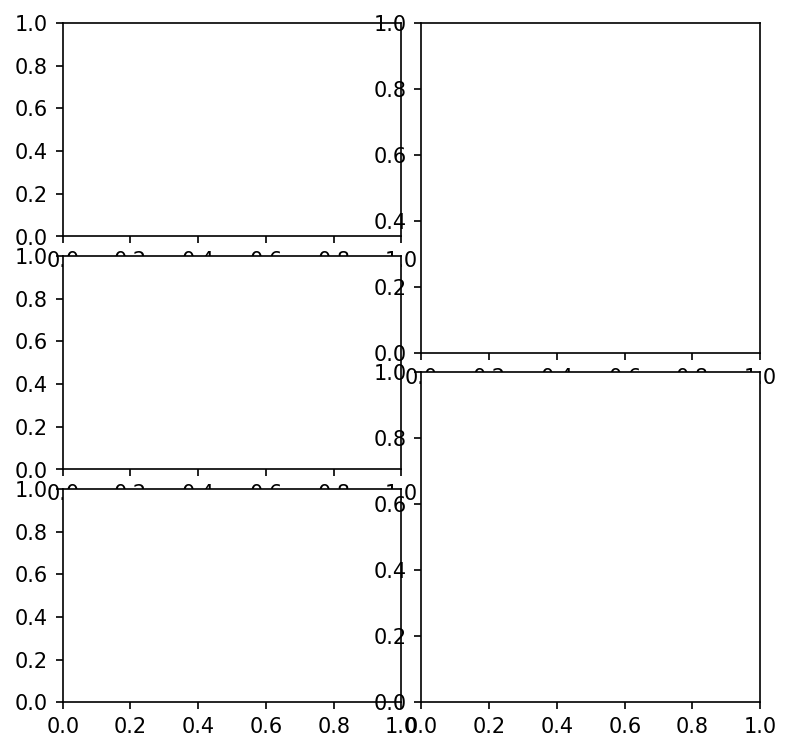

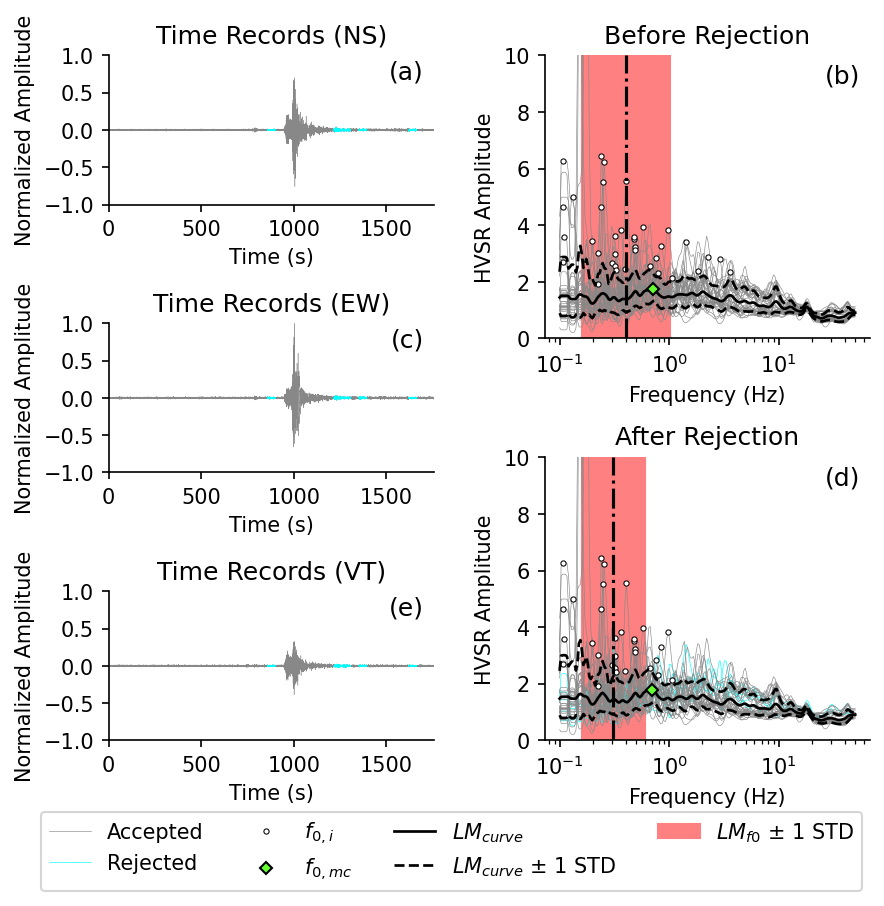

(<class 'ValueError'>, ValueError('Components are different length: ns=89878 ew=89878 vt=89876 '), <traceback object at 0x000001E48D1247C0>)
(<class 'ValueError'>, ValueError('Components are different length: ns=224921 ew=224930 vt=224803 '), <traceback object at 0x000001E48DAAA6C0>)
(<class 'ValueError'>, ValueError('Components are different length: ns=224637 ew=224637 vt=224636 '), <traceback object at 0x000001E498D90880>)
(<class 'ValueError'>, ValueError('Components are different length: ns=226753 ew=226752 vt=226752 '), <traceback object at 0x000001E48D4945C0>)
Elapsed Time: 0.16 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.17                          0.25
Fundamental Site Period, T0                 5.77                          0.25


Analysis summary:


Window length                                    45s
No. of windows                                    24
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.17                          0.25
Fundamental Site Period, T0                 5.77                          0.25

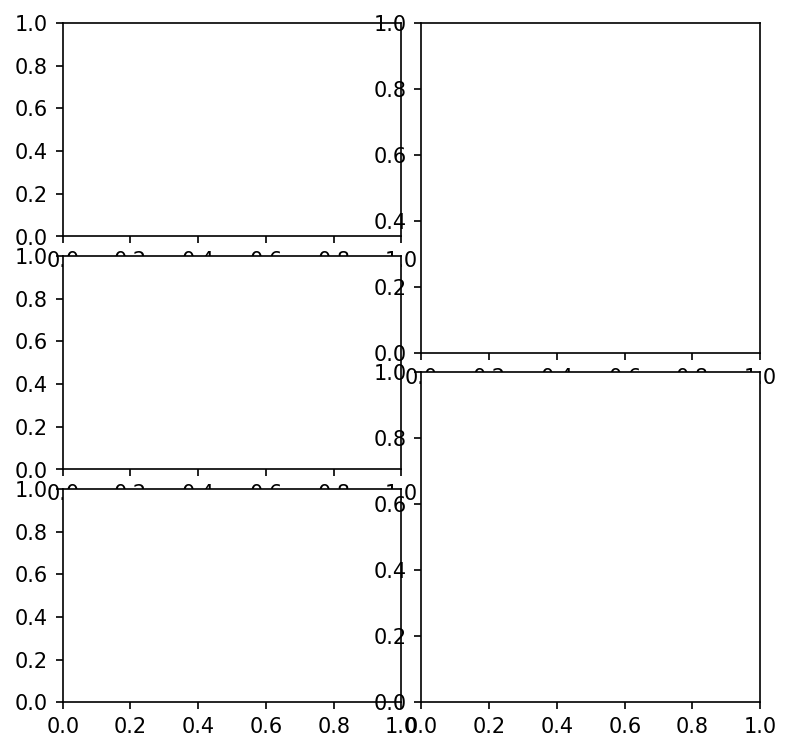

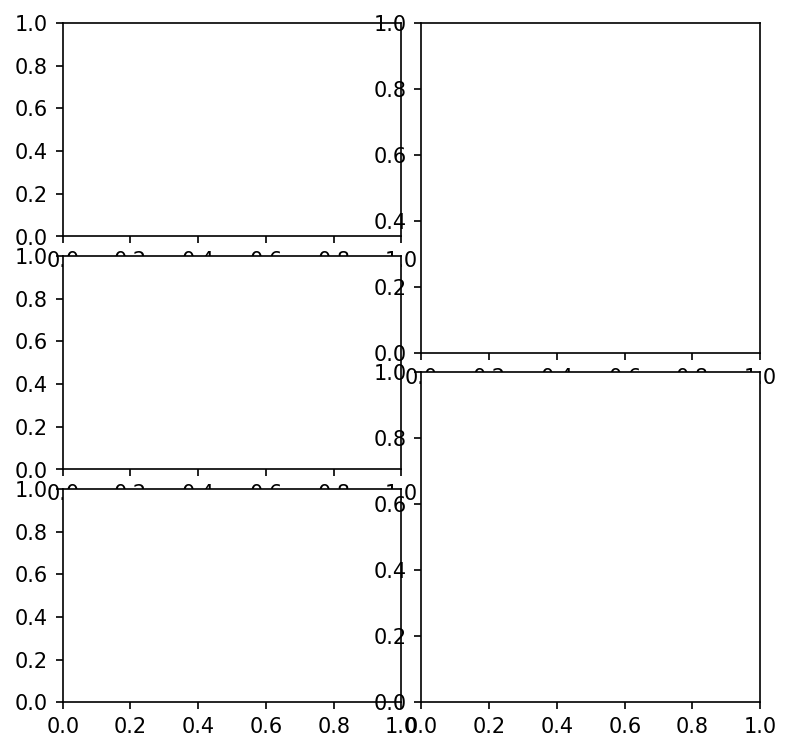

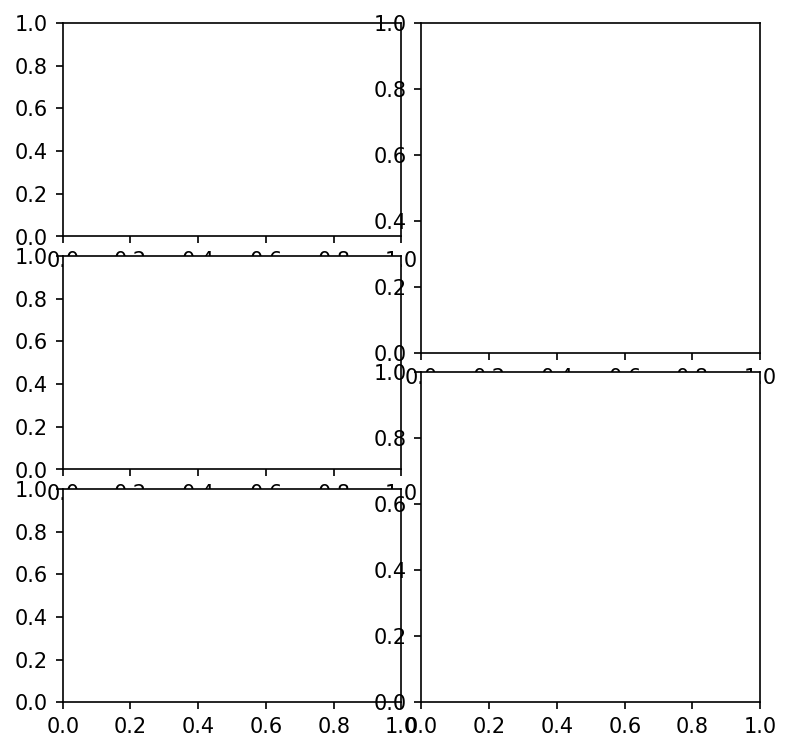

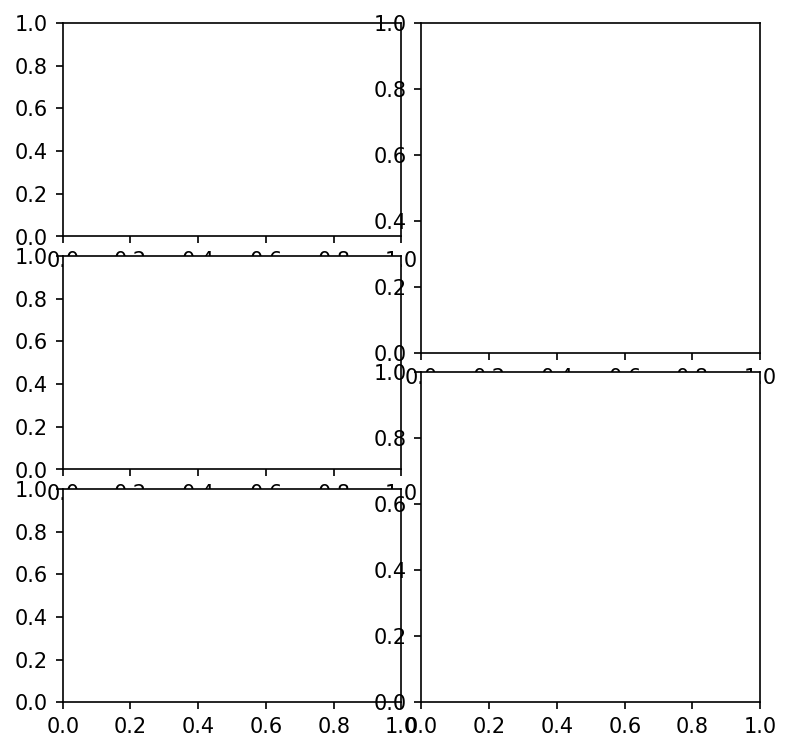

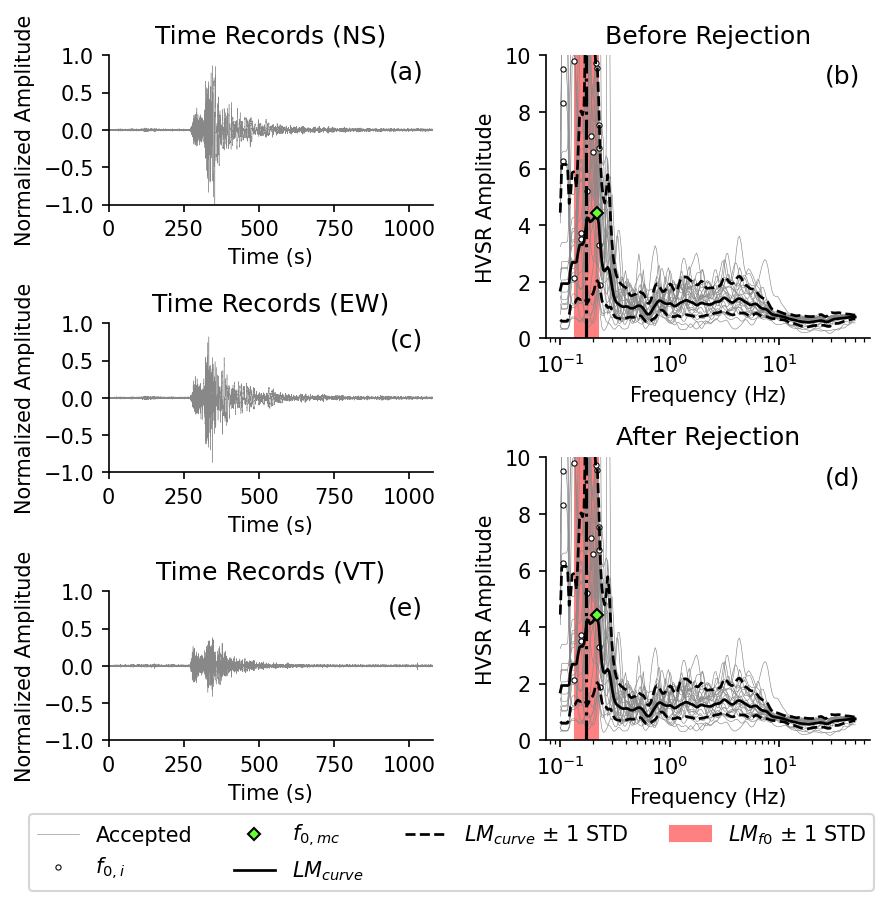

(<class 'ValueError'>, ValueError('Components are different length: ns=225001 ew=225017 vt=224893 '), <traceback object at 0x000001E48D636B00>)
(<class 'ValueError'>, ValueError('Components are different length: ns=226761 ew=226769 vt=226803 '), <traceback object at 0x000001E48DB16800>)
(<class 'ValueError'>, ValueError('Components are different length: ns=226829 ew=226825 vt=226825 '), <traceback object at 0x000001E4897FB480>)
(<class 'ValueError'>, ValueError('Components are different length: ns=224907 ew=224750 vt=224771 '), <traceback object at 0x000001E4989F2EC0>)
(<class 'ValueError'>, ValueError('Components are different length: ns=222746 ew=222610 vt=222948 '), <traceback object at 0x000001E48D0BC600>)
Elapsed Time: 0.11 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.48                          1.82
Fundamental Site Period, T0                 2.10                          1.82


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  6 of 50 allowed
No. of rejected windows                           11


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.17                          0.41
Fundamental Site Period, T0                 5.72                          0.41

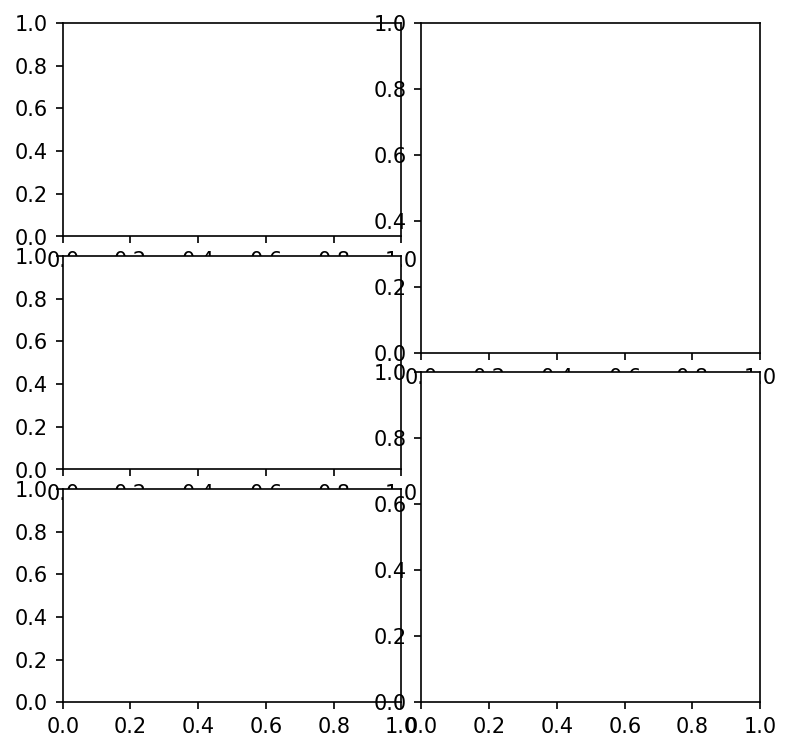

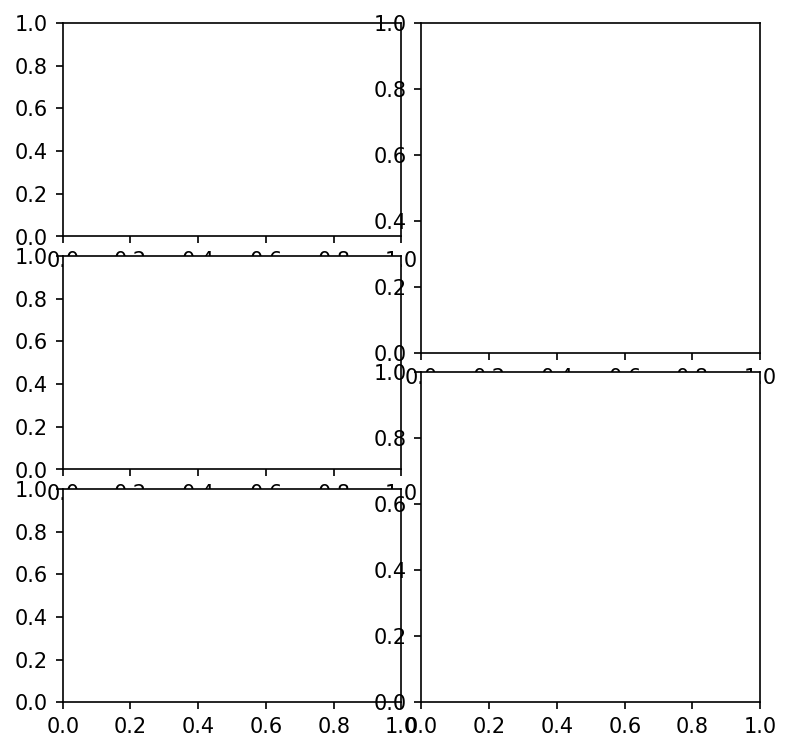

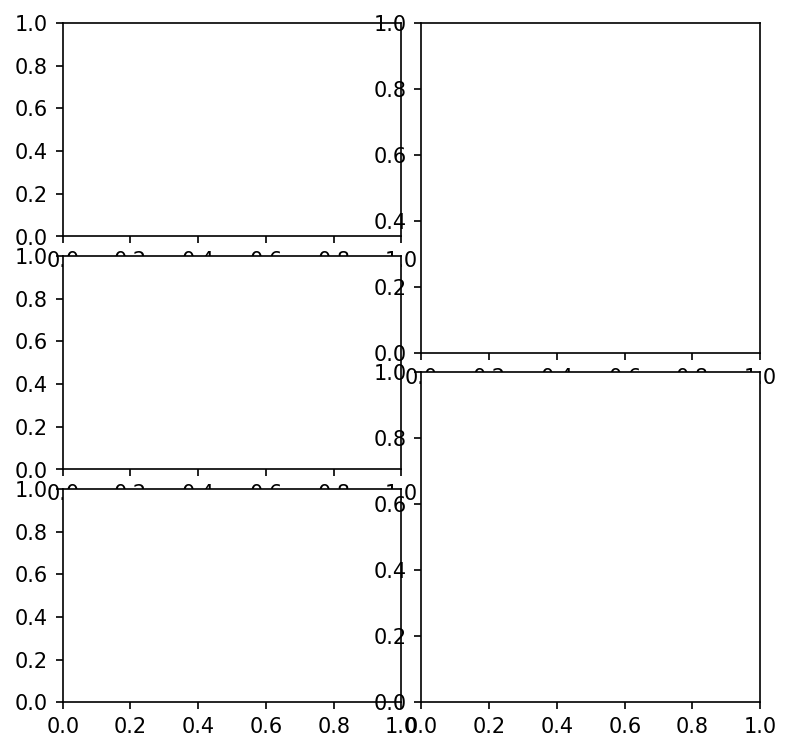

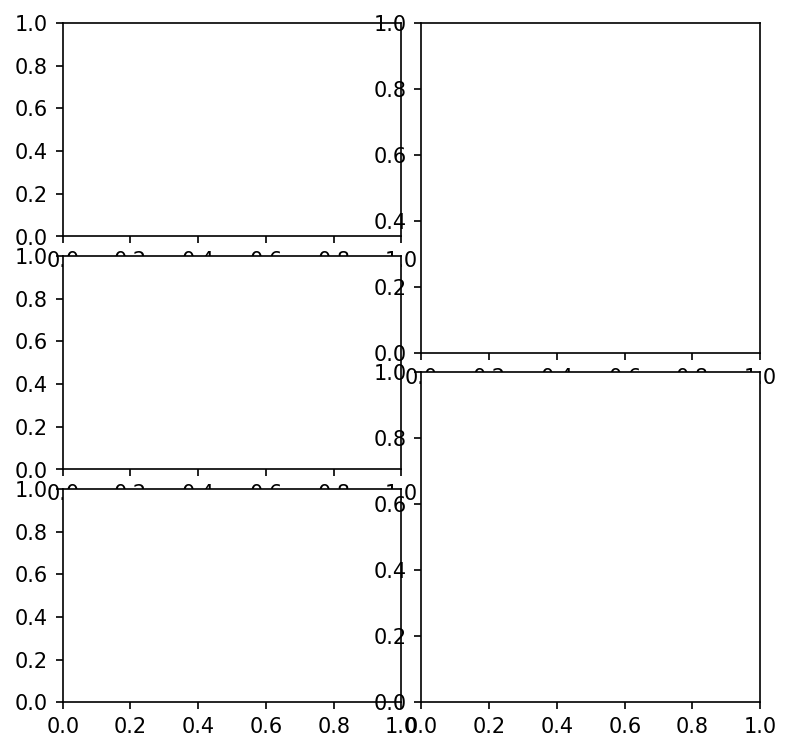

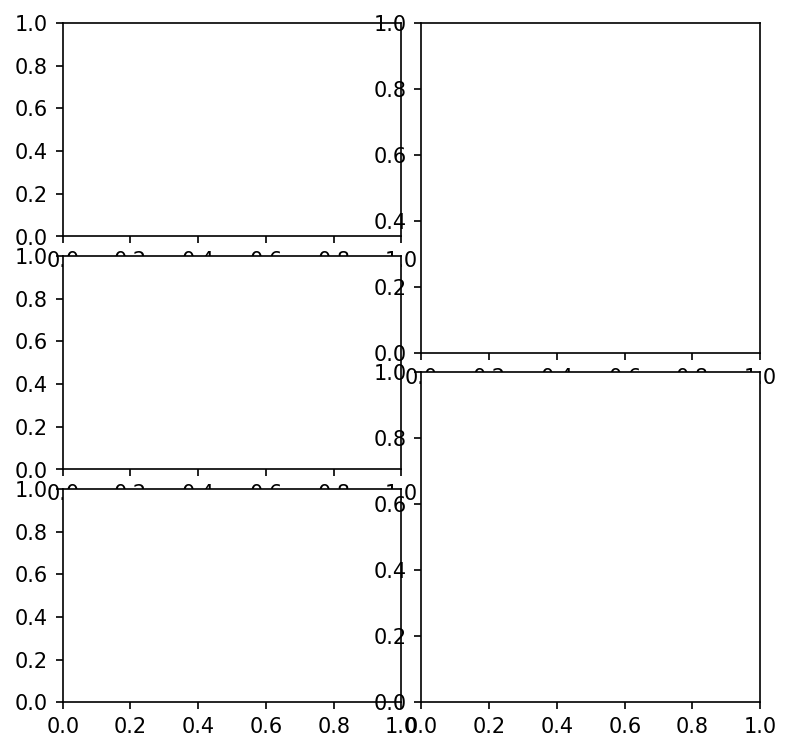

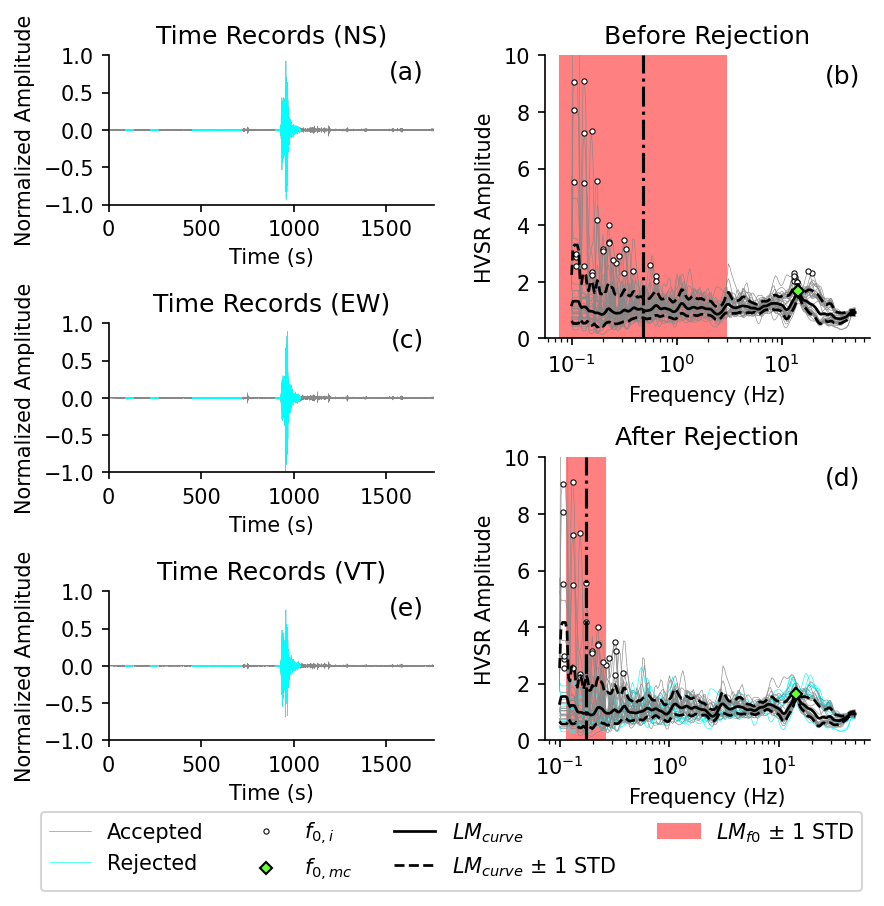

(<class 'ValueError'>, ValueError('Components are different length: ns=226826 ew=226944 vt=226636 '), <traceback object at 0x000001E48D41A9C0>)
(<class 'ValueError'>, ValueError('Components are different length: ns=224743 ew=224741 vt=224741 '), <traceback object at 0x000001E48DB33D40>)
(<class 'ValueError'>, ValueError('Components are different length: ns=224772 ew=224792 vt=224822 '), <traceback object at 0x000001E4911D49C0>)
(<class 'ValueError'>, ValueError('Components are different length: ns=226769 ew=226784 vt=226784 '), <traceback object at 0x000001E4912D2580>)
(<class 'ValueError'>, ValueError('Components are different length: ns=226792 ew=226821 vt=226815 '), <traceback object at 0x000001E491C73300>)
(<class 'ValueError'>, ValueError('Components are different length: ns=222997 ew=222995 vt=222947 '), <traceback object at 0x000001E492D40F80>)
(<class 'ValueError'>, ValueError('Components are different length: ns=224865 ew=224865 vt=224864 '), <traceback object at 0x000001E4931

Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.28                          0.99
Fundamental Site Period, T0                 3.53                          0.99


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  4 of 50 allowed
No. of rejected windows                            6


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0               0.2                          0.37
Fundamental Site Period, T0                  5.0                          0.37

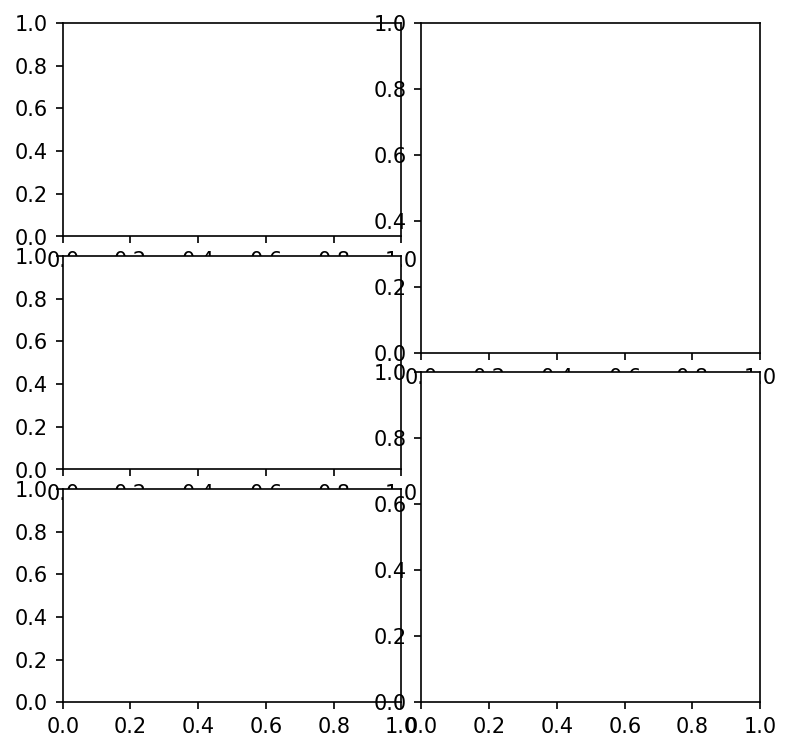

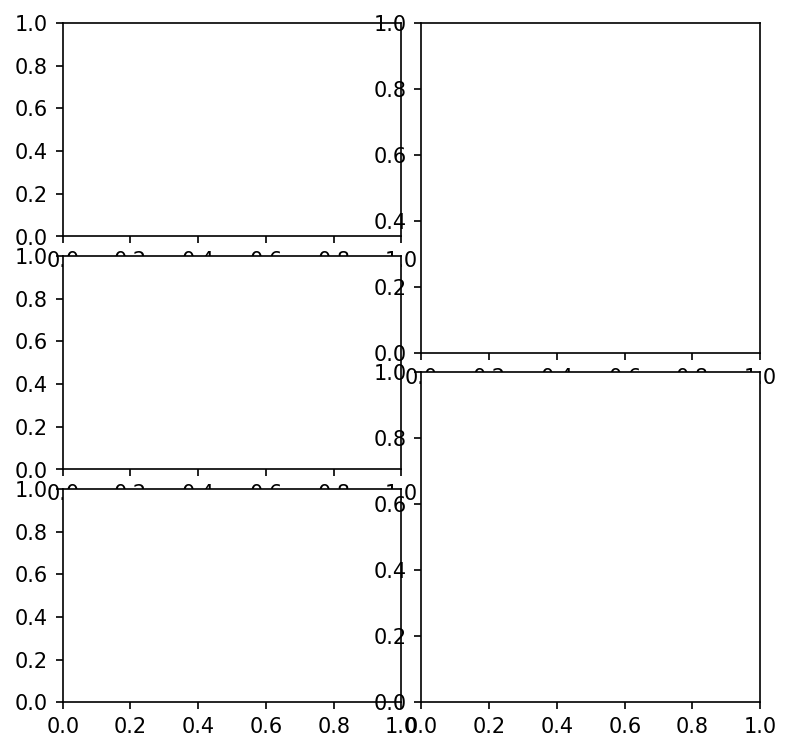

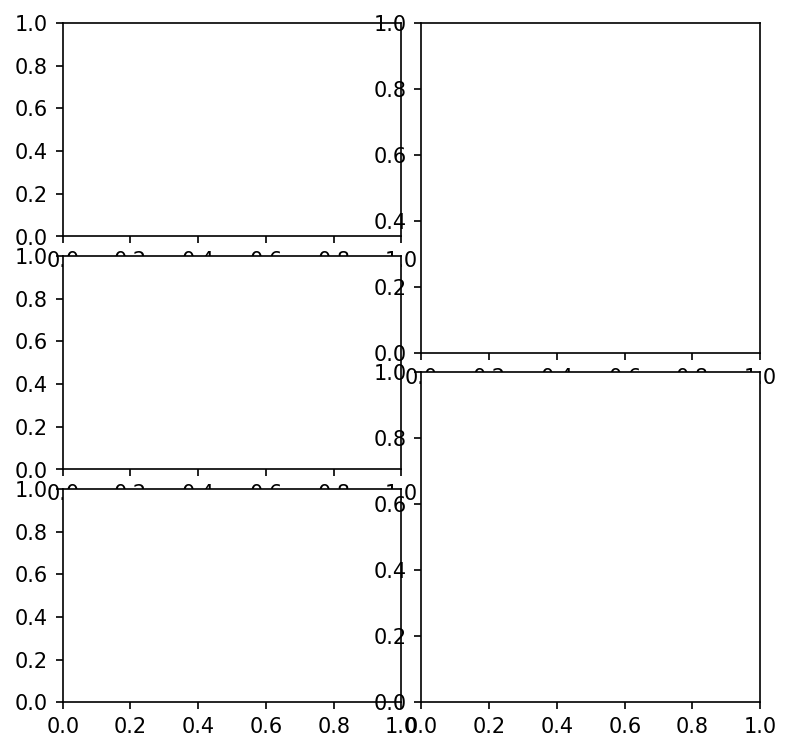

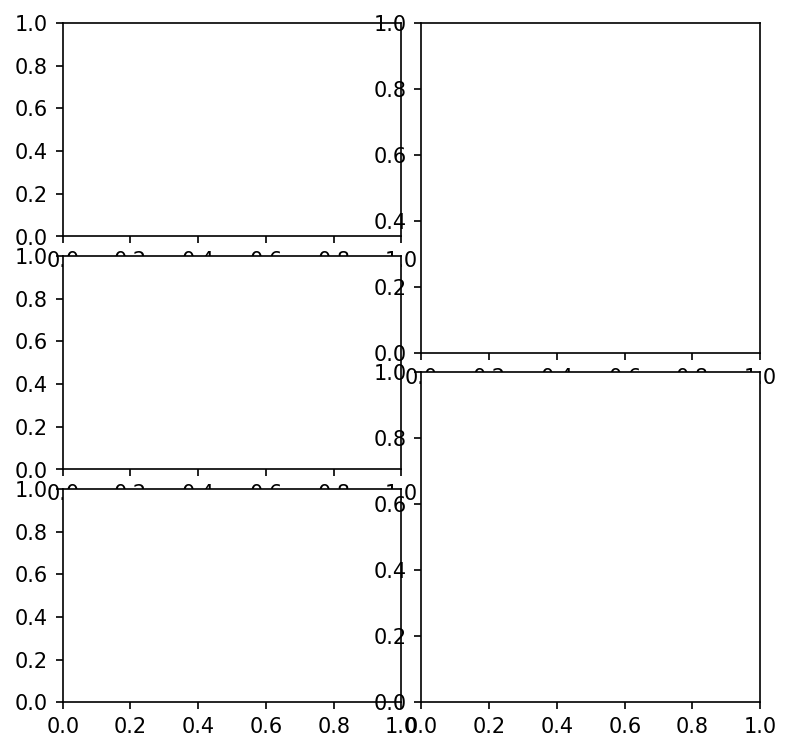

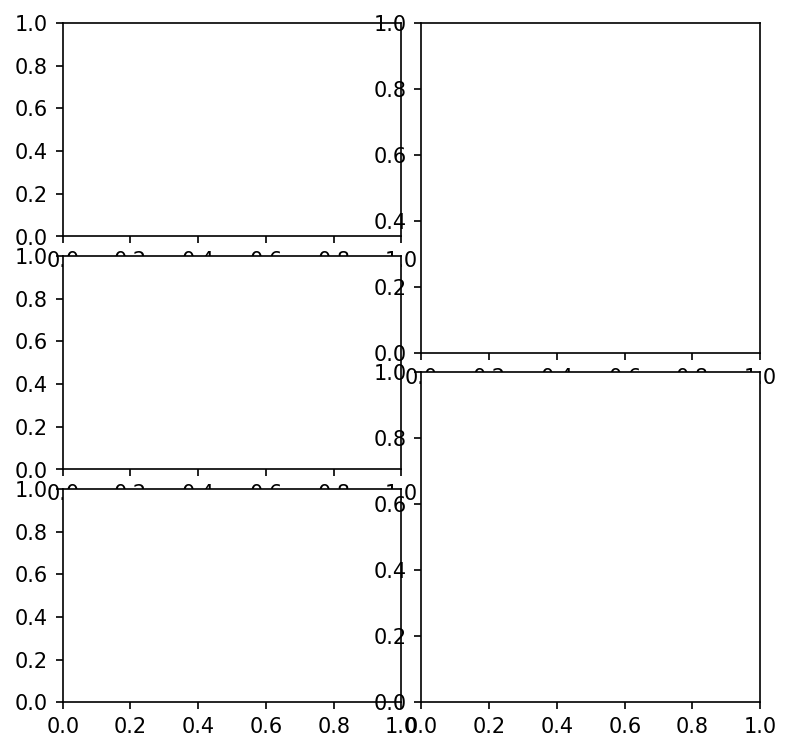

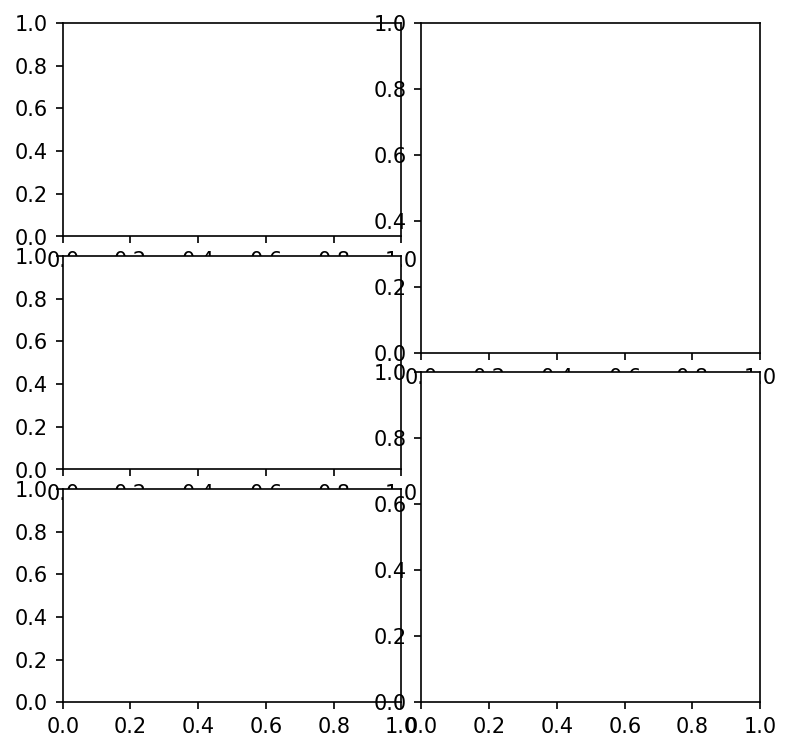

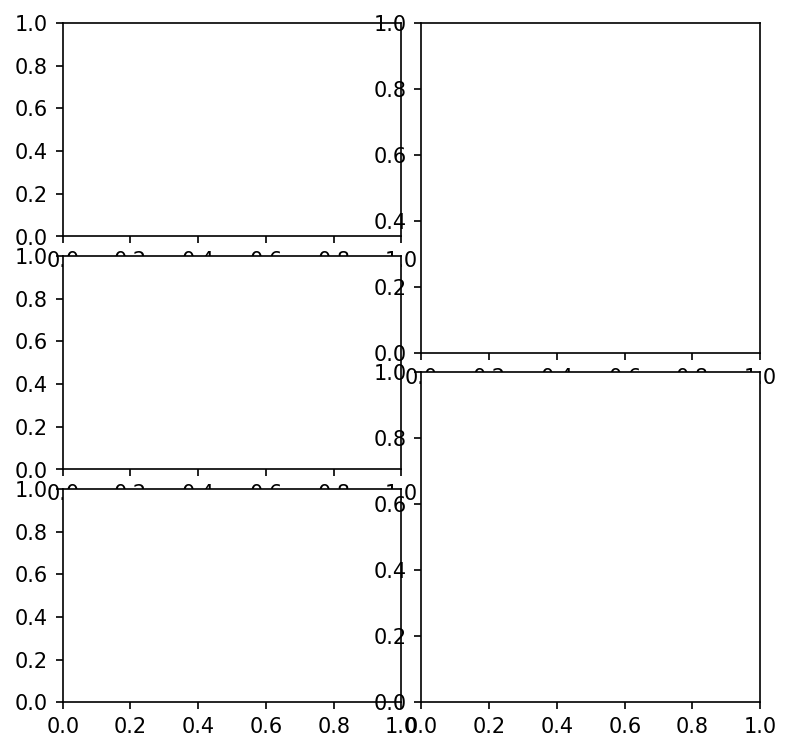

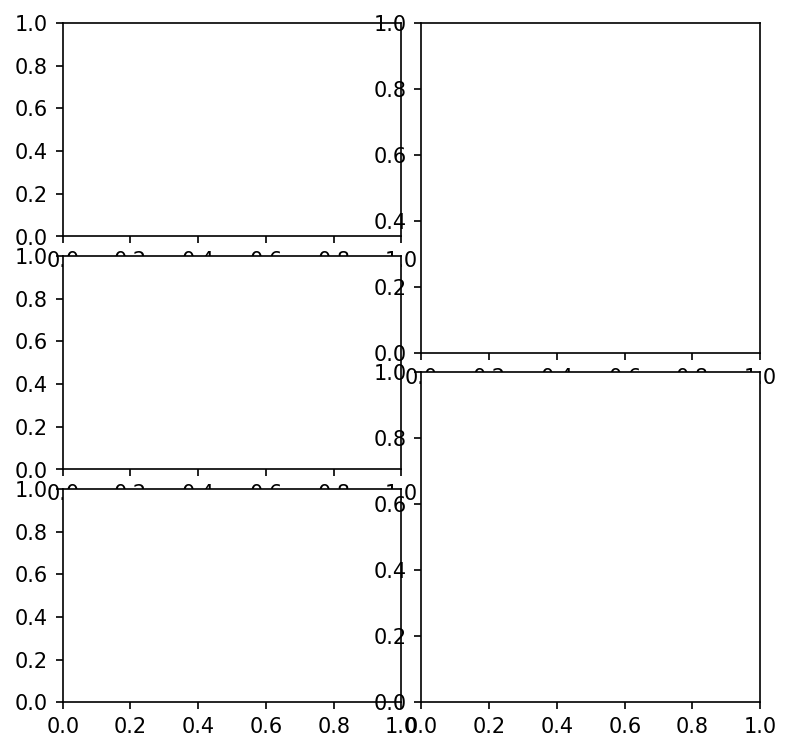

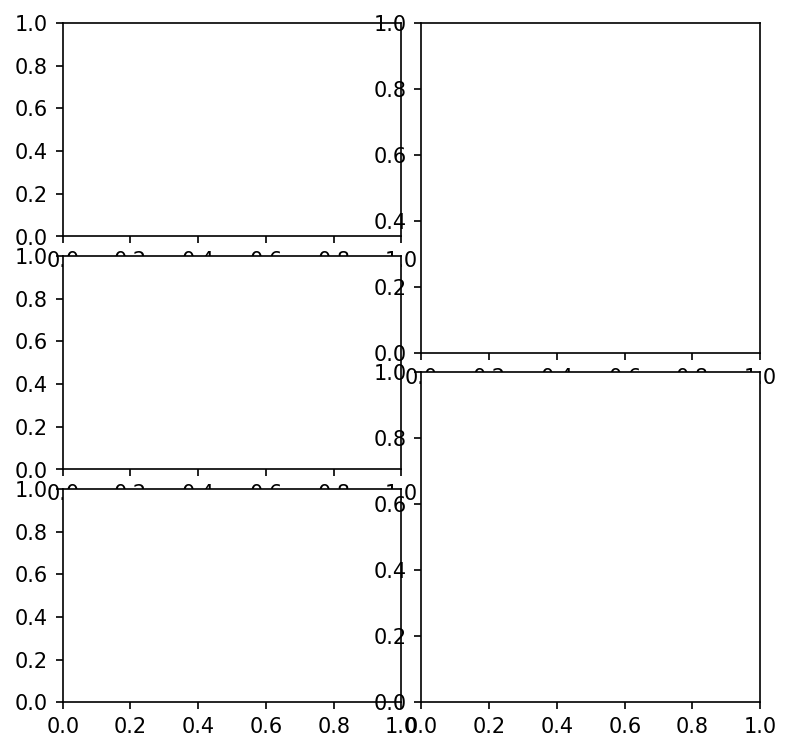

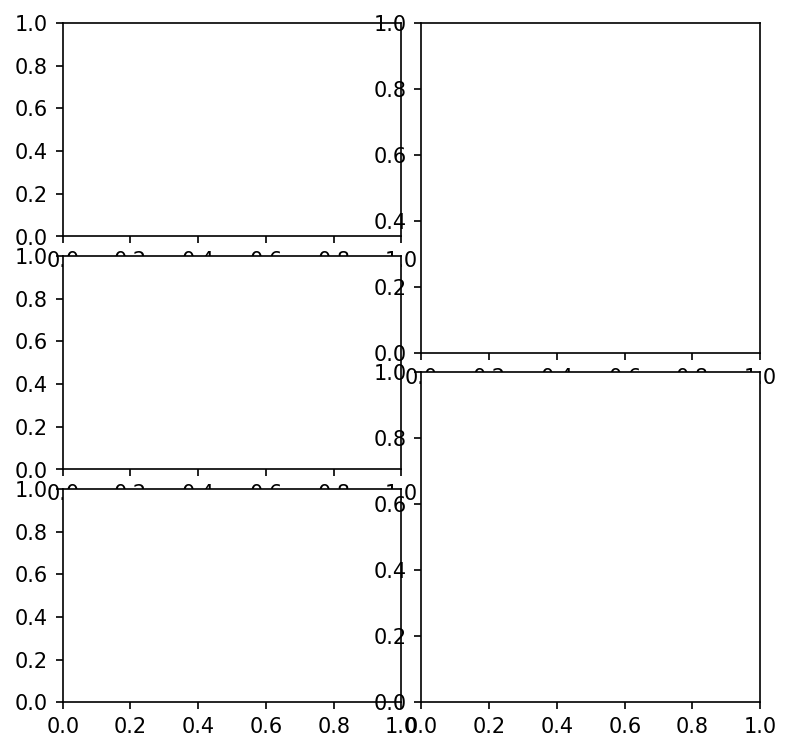

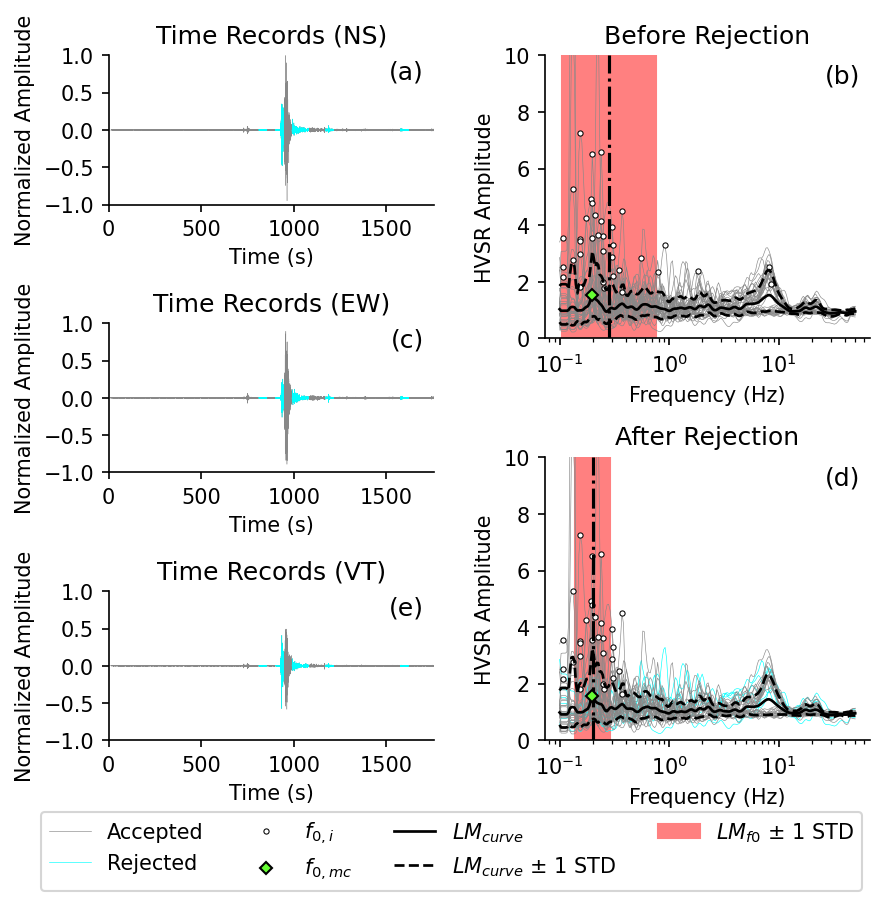

(<class 'ValueError'>, ValueError('Components are different length: ns=226643 ew=226785 vt=226849 '), <traceback object at 0x000001E4898A0F40>)
(<class 'ValueError'>, ValueError('Components are different length: ns=224991 ew=224893 vt=224663 '), <traceback object at 0x000001E48DAC9C80>)
(<class 'ValueError'>, ValueError('Components are different length: ns=222798 ew=222907 vt=222728 '), <traceback object at 0x000001E48DA34700>)
Elapsed Time: 0.05 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.43                          1.55
Fundamental Site Period, T0                 2.34                          1.55


Analysis summary:


Window length                                    45s
No. of windows                                     4
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.43                          1.55
Fundamental Site Period, T0                 2.34                          1.55

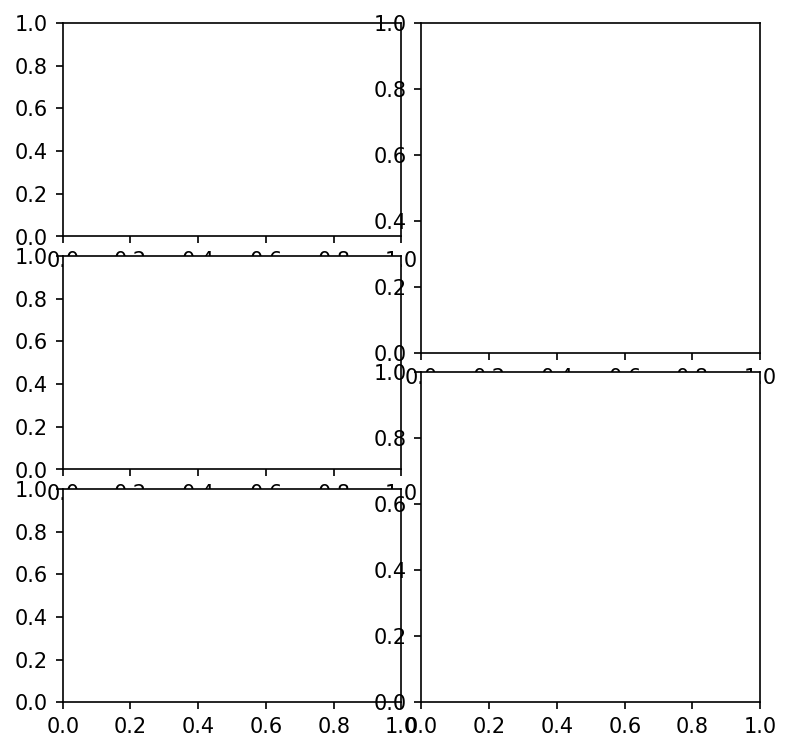

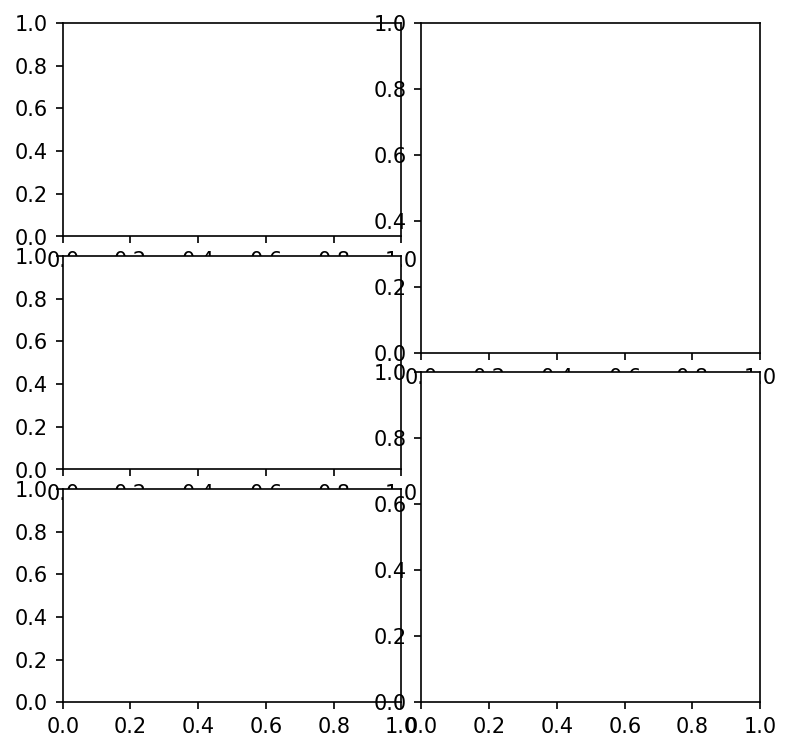

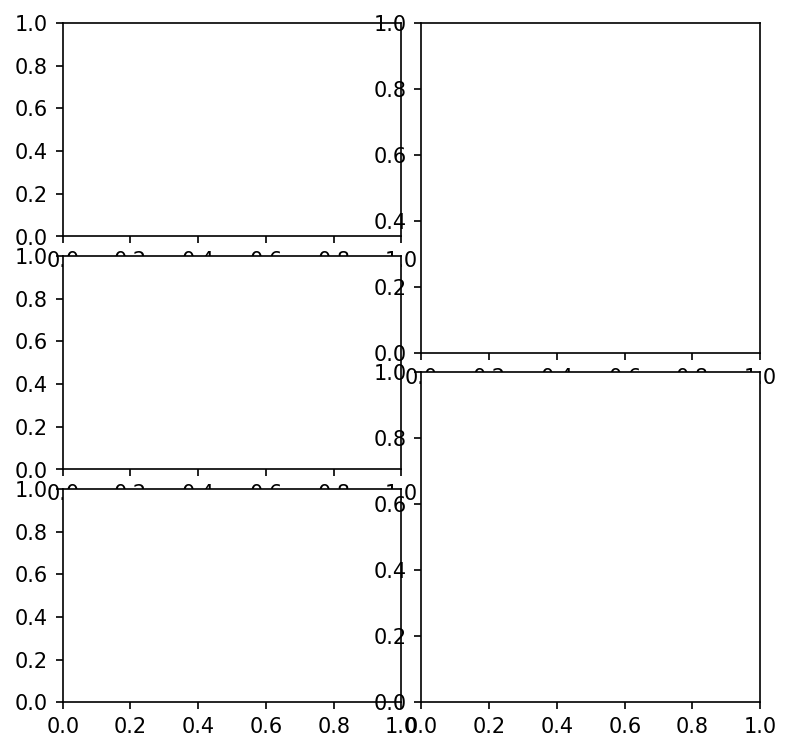

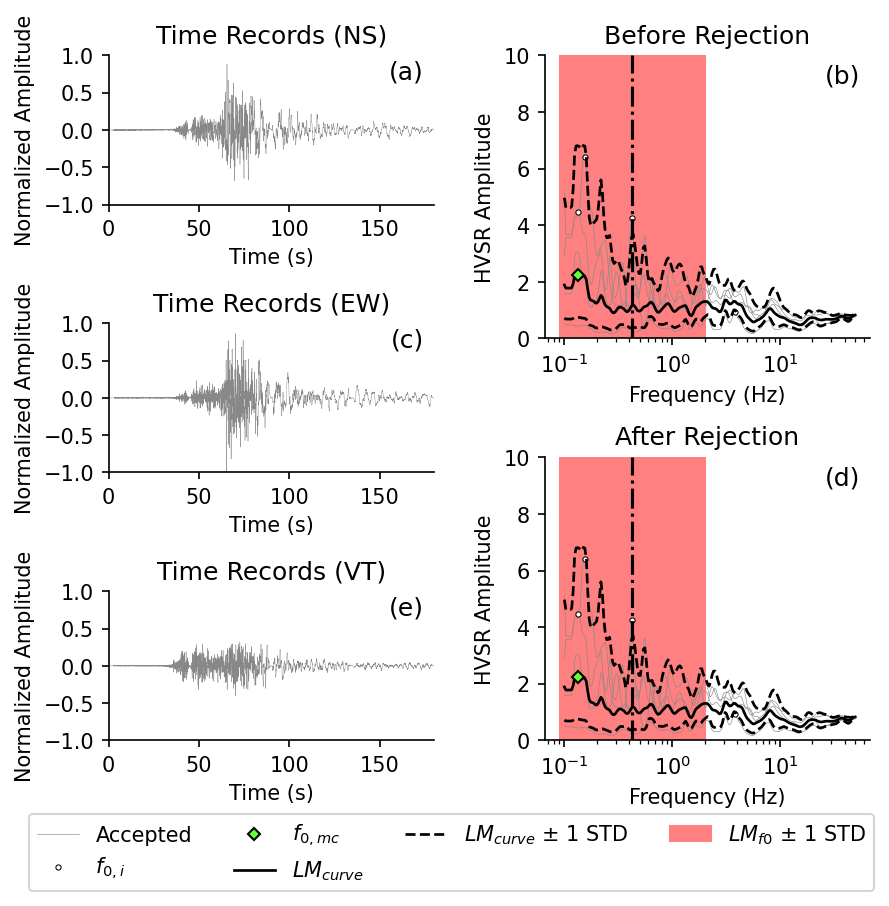

(<class 'ValueError'>, ValueError('Components are different length: ns=224919 ew=224918 vt=224898 '), <traceback object at 0x000001E495A3FC80>)
(<class 'ValueError'>, ValueError('Components are different length: ns=226913 ew=226869 vt=226813 '), <traceback object at 0x000001E489B80B80>)
(<class 'ValueError'>, ValueError('Components are different length: ns=226719 ew=226713 vt=226961 '), <traceback object at 0x000001E4931DF040>)
(<class 'ValueError'>, ValueError('Components are different length: ns=226779 ew=226780 vt=226789 '), <traceback object at 0x000001E48D6E4B80>)
(<class 'ValueError'>, ValueError('Components are different length: ns=224894 ew=224882 vt=224902 '), <traceback object at 0x000001E489862940>)
(<class 'ValueError'>, ValueError('Components are different length: ns=222693 ew=222691 vt=222693 '), <traceback object at 0x000001E48D8A8540>)
Elapsed Time: 0.10 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.35                           1.1
Fundamental Site Period, T0                 2.86                           1.1


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  9 of 50 allowed
No. of rejected windows                           12


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.19                          0.37
Fundamental Site Period, T0                 5.21                          0.37

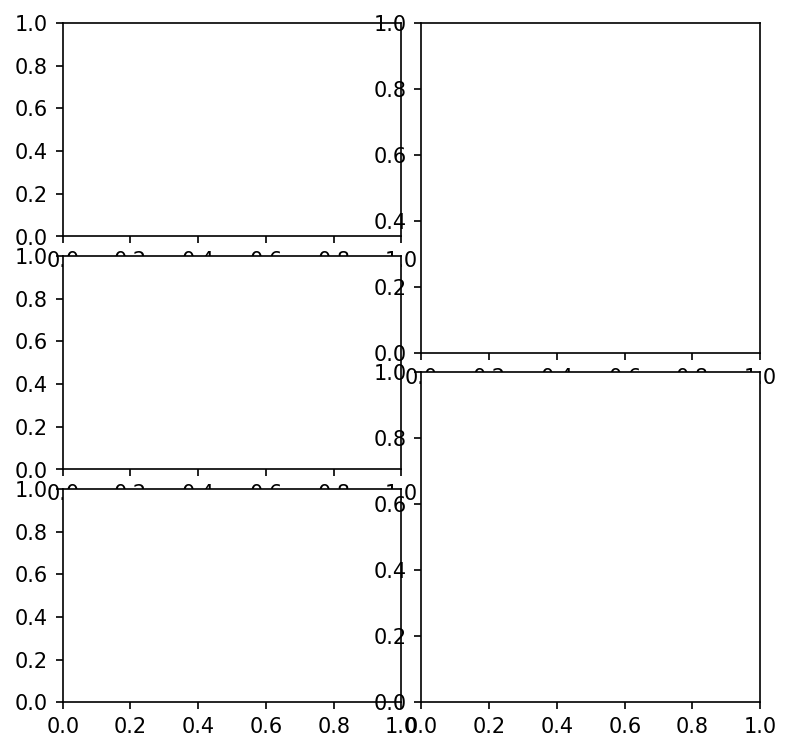

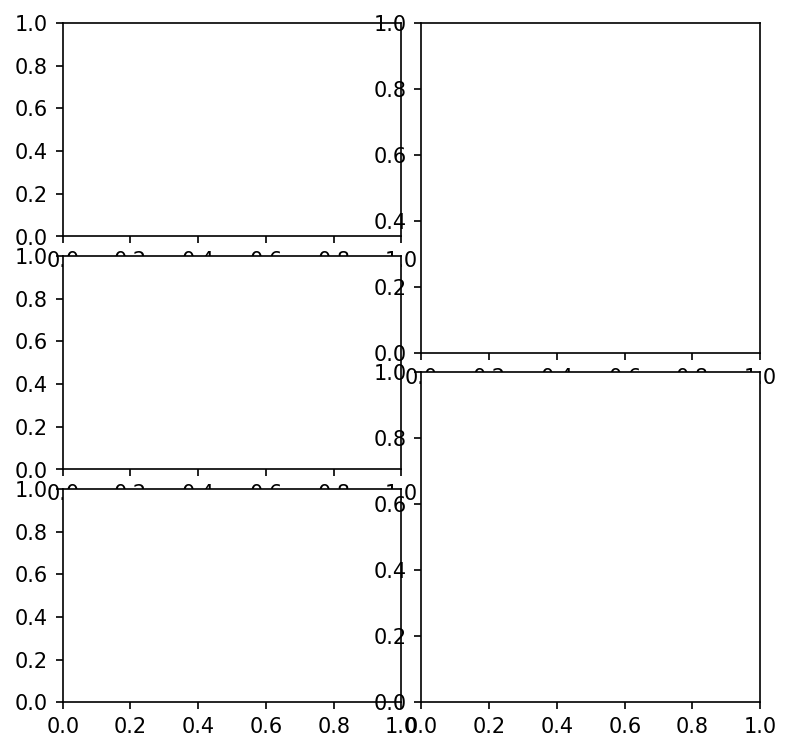

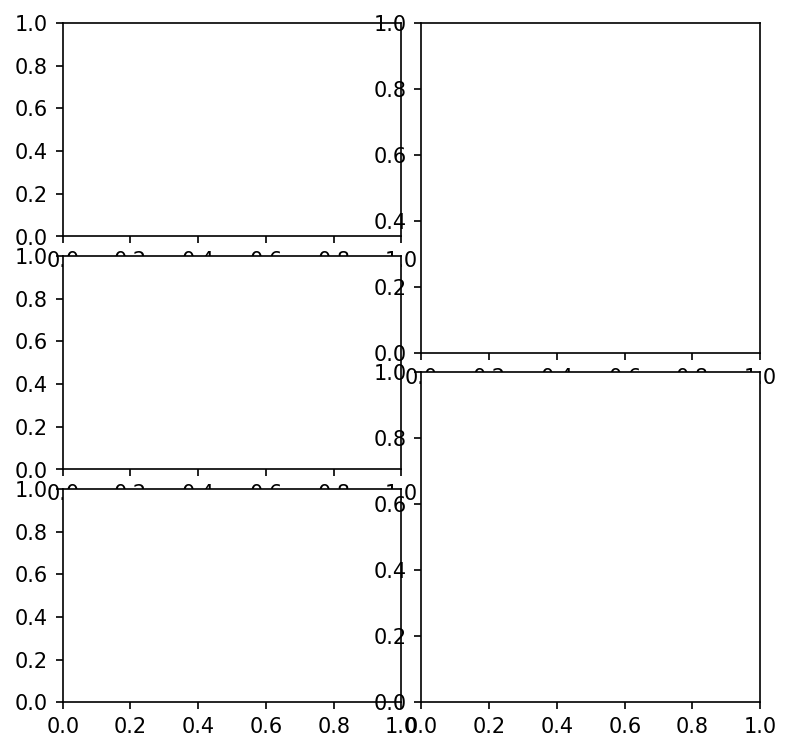

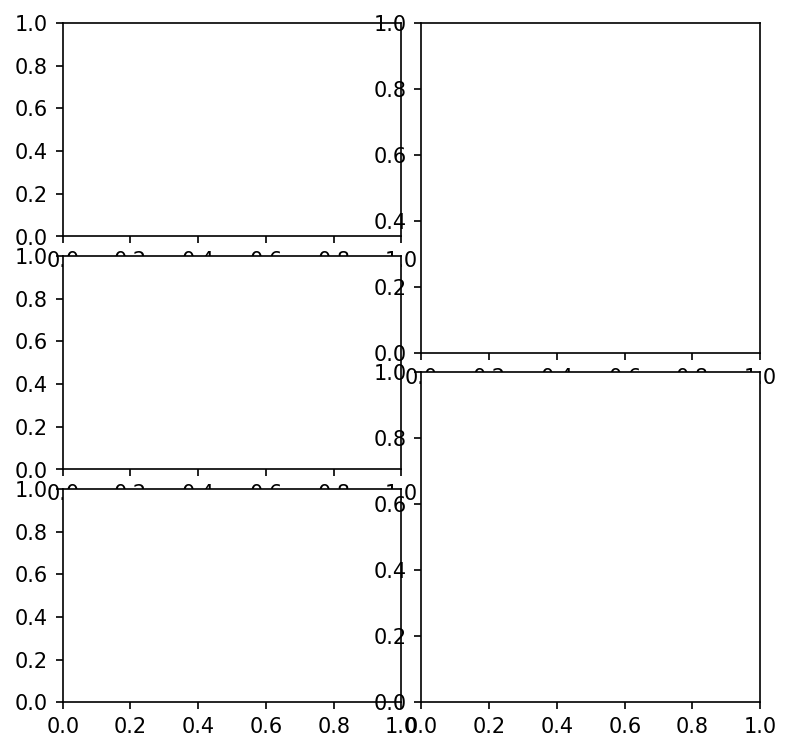

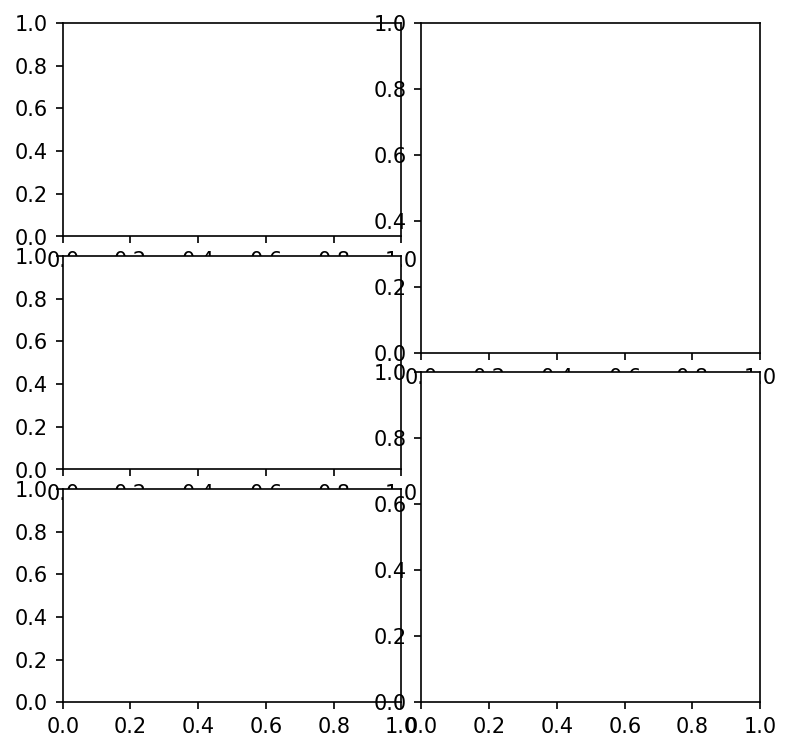

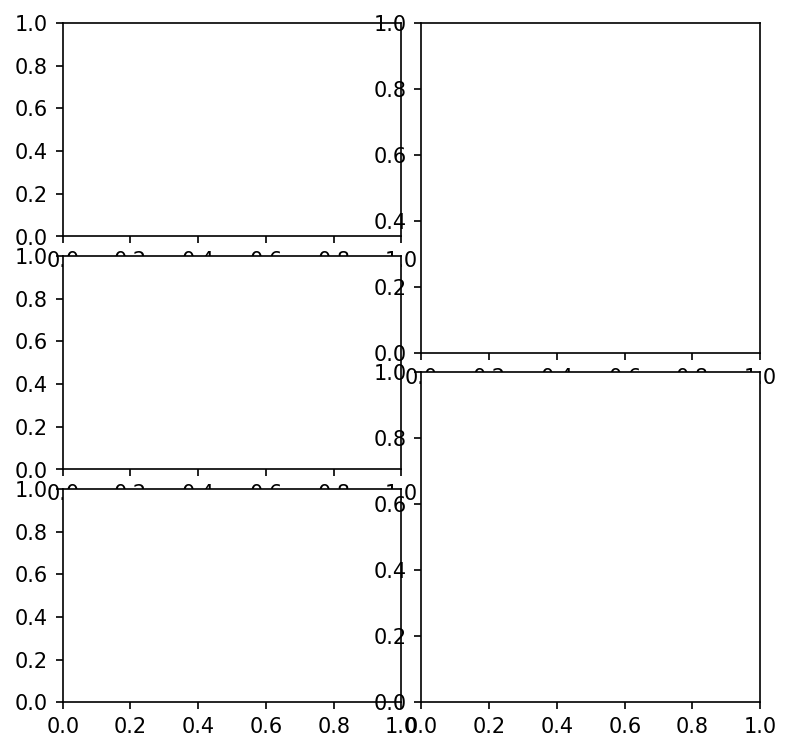

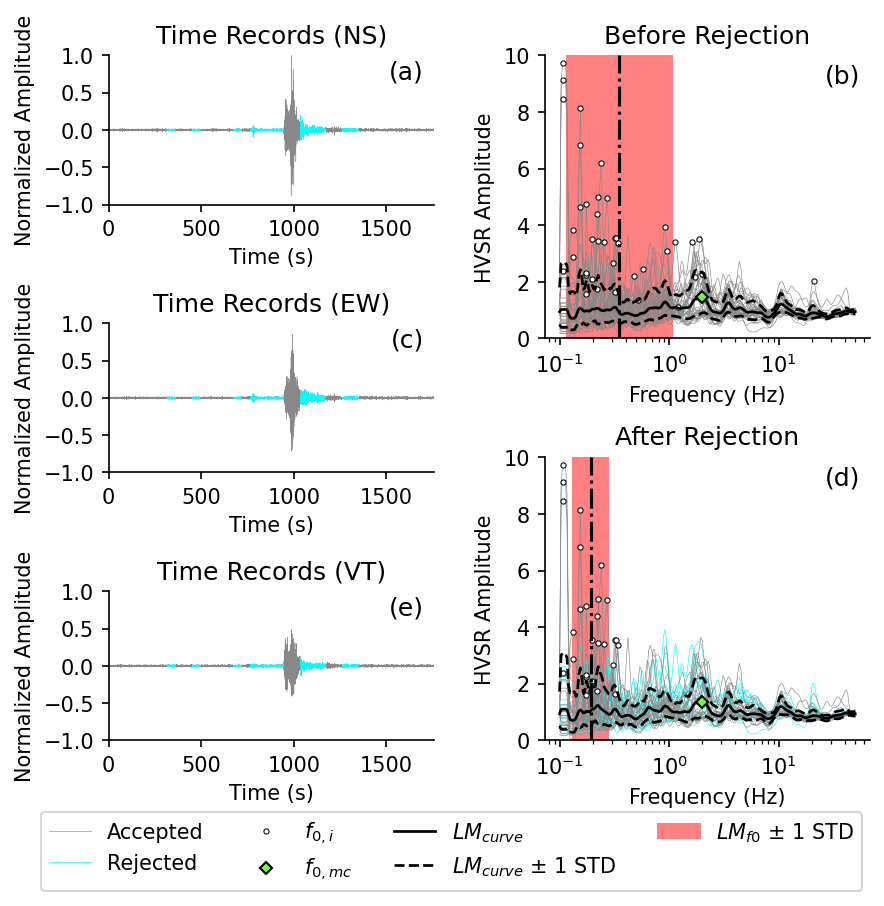

(<class 'ValueError'>, ValueError('Components are different length: ns=222708 ew=222731 vt=222827 '), <traceback object at 0x000001E4996B0840>)
Elapsed Time: 0.15 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.24                          0.57
Fundamental Site Period, T0                 4.20                          0.57


Analysis summary:


Window length                                    45s
No. of windows                                    24
Number of iterations to convergence  3 of 50 allowed
No. of rejected windows                            2


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.21                          0.45
Fundamental Site Period, T0                 4.69                          0.45

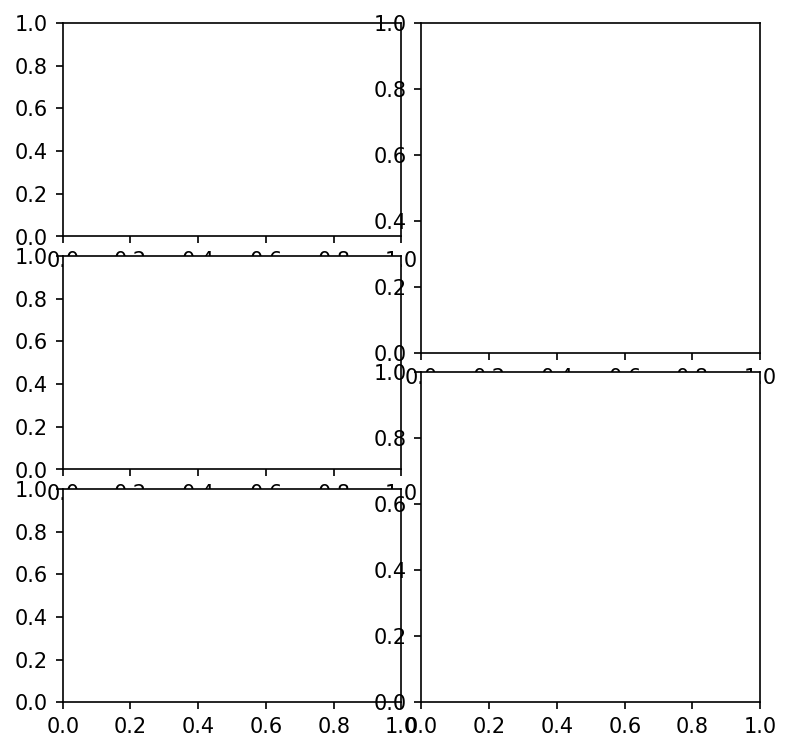

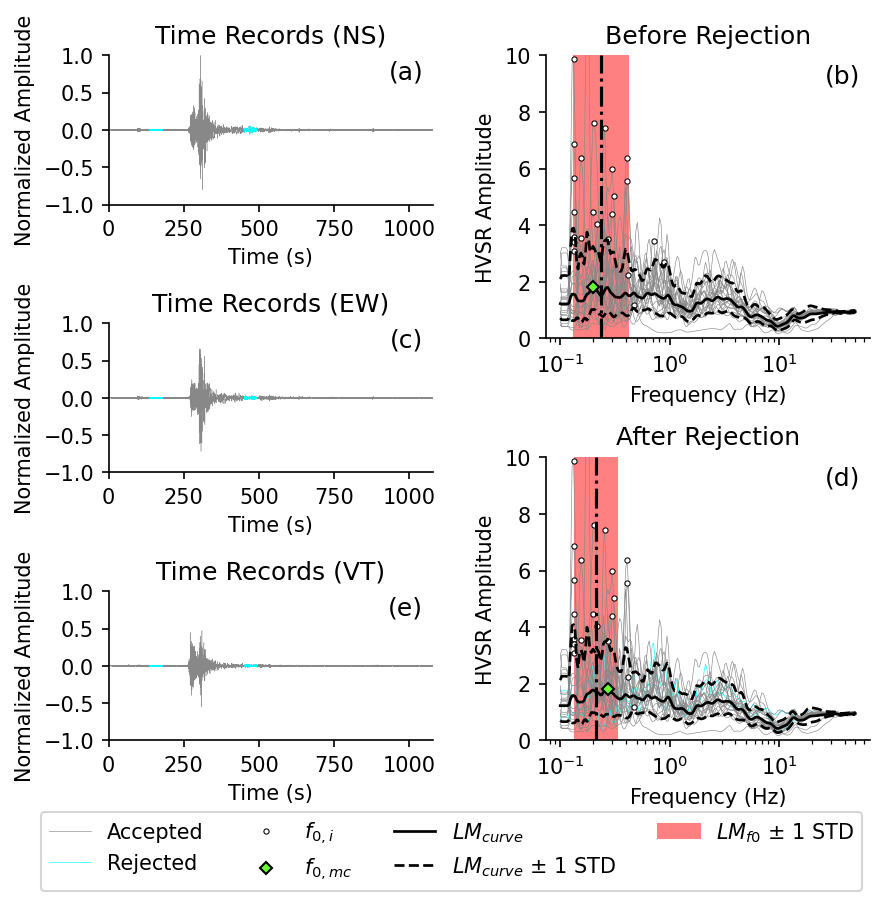

(<class 'ValueError'>, ValueError('Components are different length: ns=222786 ew=222850 vt=222642 '), <traceback object at 0x000001E4F9EA2C40>)
Elapsed Time: 0.15 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.26                          0.59
Fundamental Site Period, T0                 3.87                          0.59


Analysis summary:


Window length                                    45s
No. of windows                                    24
Number of iterations to convergence  2 of 50 allowed
No. of rejected windows                            1


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.24                          0.47
Fundamental Site Period, T0                 4.16                          0.47

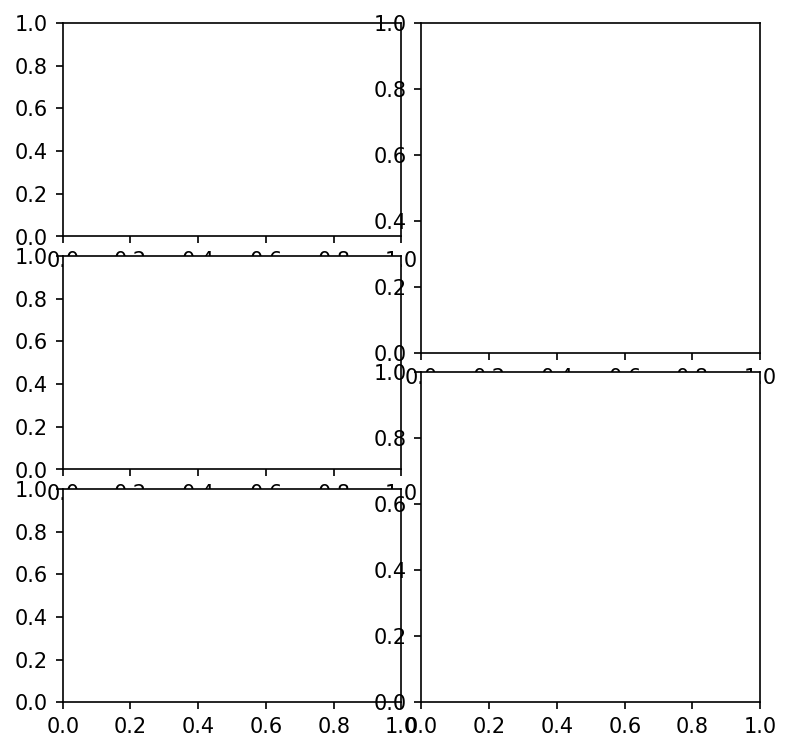

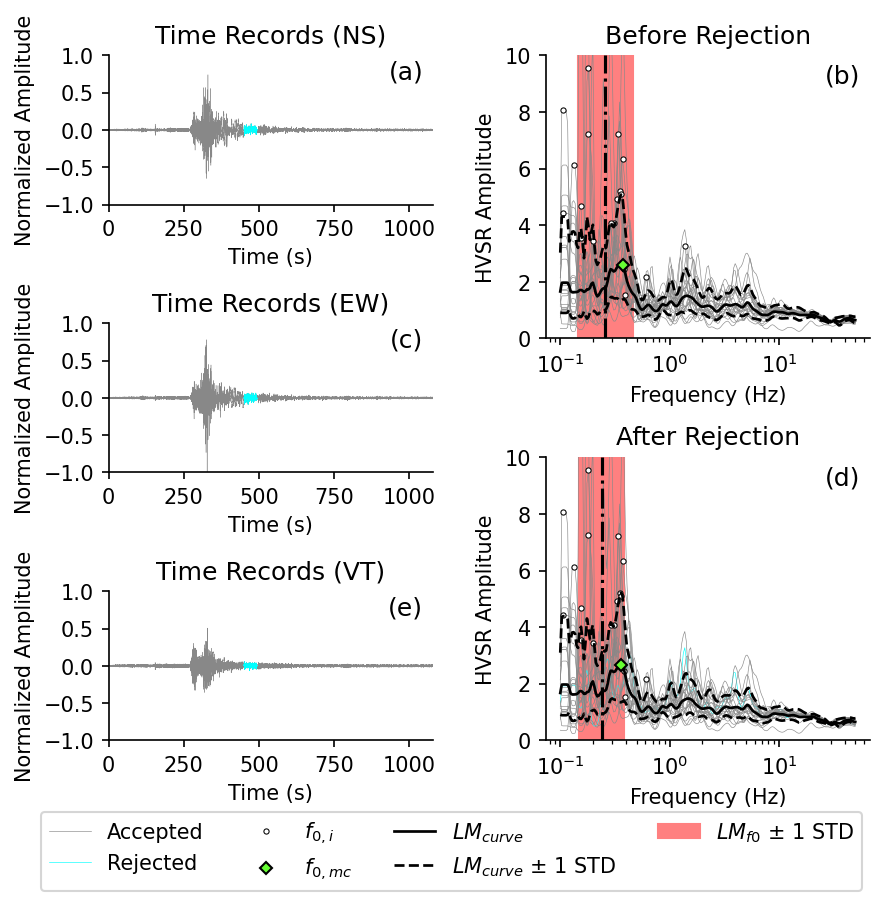

Elapsed Time: 0.11 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.39                          1.37
Fundamental Site Period, T0                 2.59                          1.37


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  5 of 50 allowed
No. of rejected windows                            9


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.20                          0.45
Fundamental Site Period, T0                 4.99                          0.45

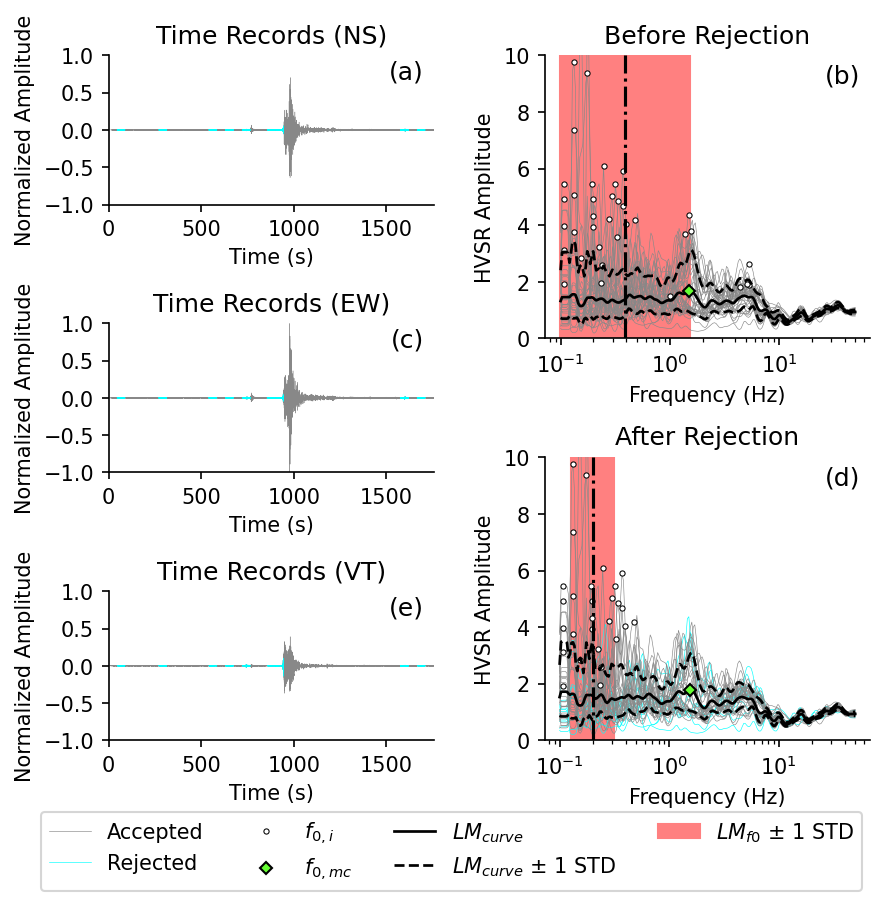

Elapsed Time: 0.11 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.39                          1.32
Fundamental Site Period, T0                 2.57                          1.32


Analysis summary:


Window length                                     45s
No. of windows                                     39
Number of iterations to convergence  15 of 50 allowed
No. of rejected windows                            23


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.16                           0.1
Fundamental Site Period, T0                 6.45                           0.1

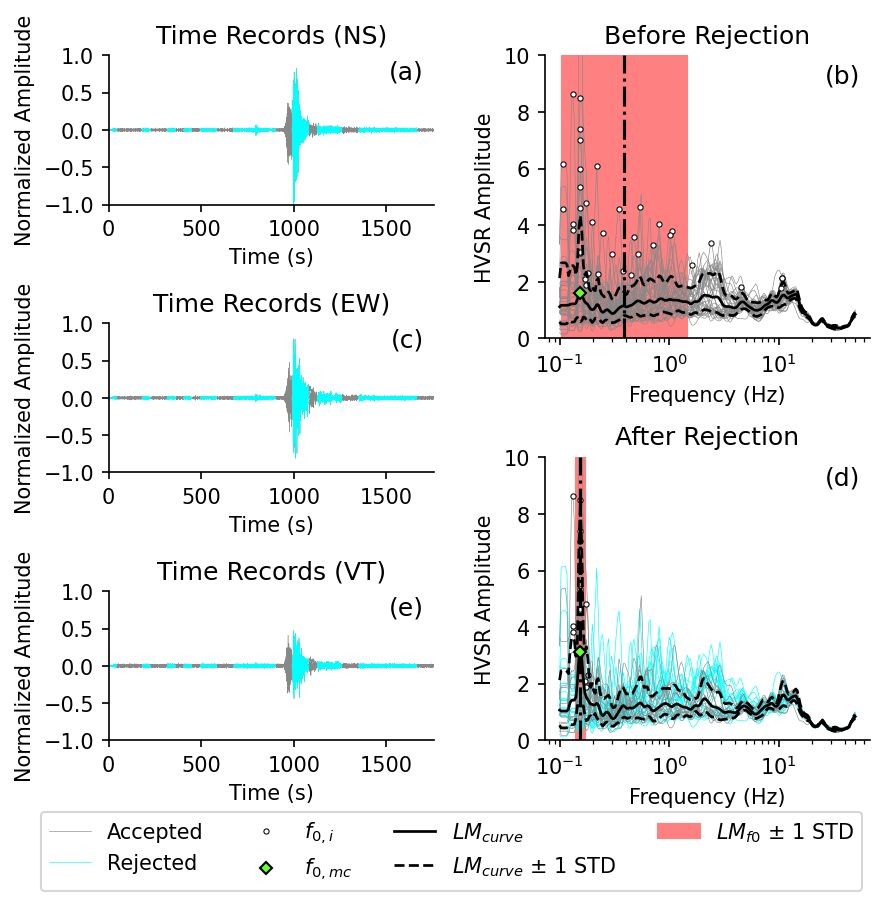

Elapsed Time: 0.10 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.23                          0.63
Fundamental Site Period, T0                 4.29                          0.63


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  3 of 50 allowed
No. of rejected windows                            3


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.21                          0.42
Fundamental Site Period, T0                 4.86                          0.42

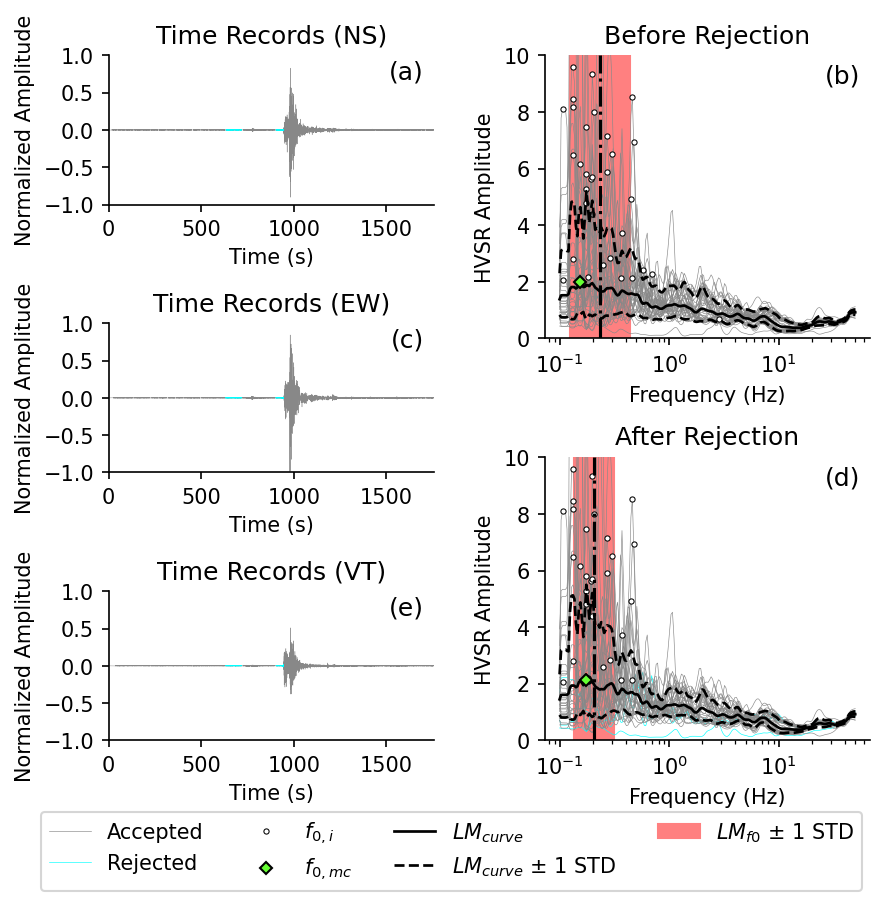

Elapsed Time: 0.14 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.76                          1.52
Fundamental Site Period, T0                 1.31                          1.52


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.76                          1.52
Fundamental Site Period, T0                 1.31                          1.52

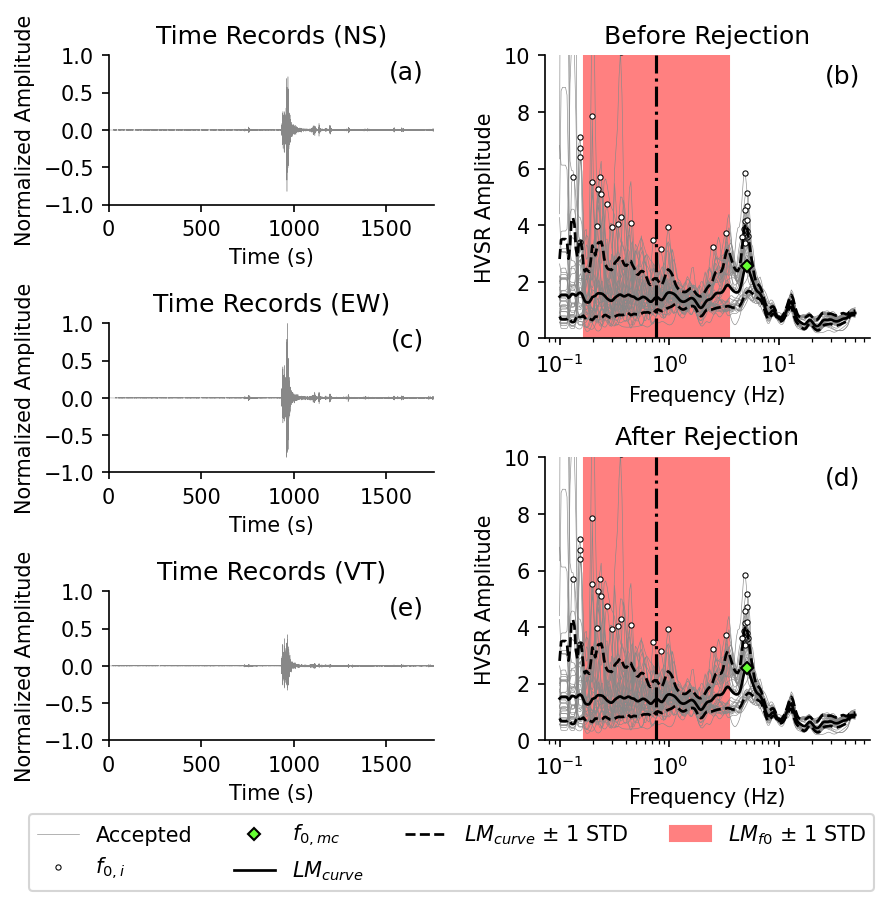

Elapsed Time: 0.13 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0               0.2                          0.77
Fundamental Site Period, T0                  5.0                          0.77


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  5 of 50 allowed
No. of rejected windows                            8


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.15                          0.22
Fundamental Site Period, T0                 6.87                          0.22

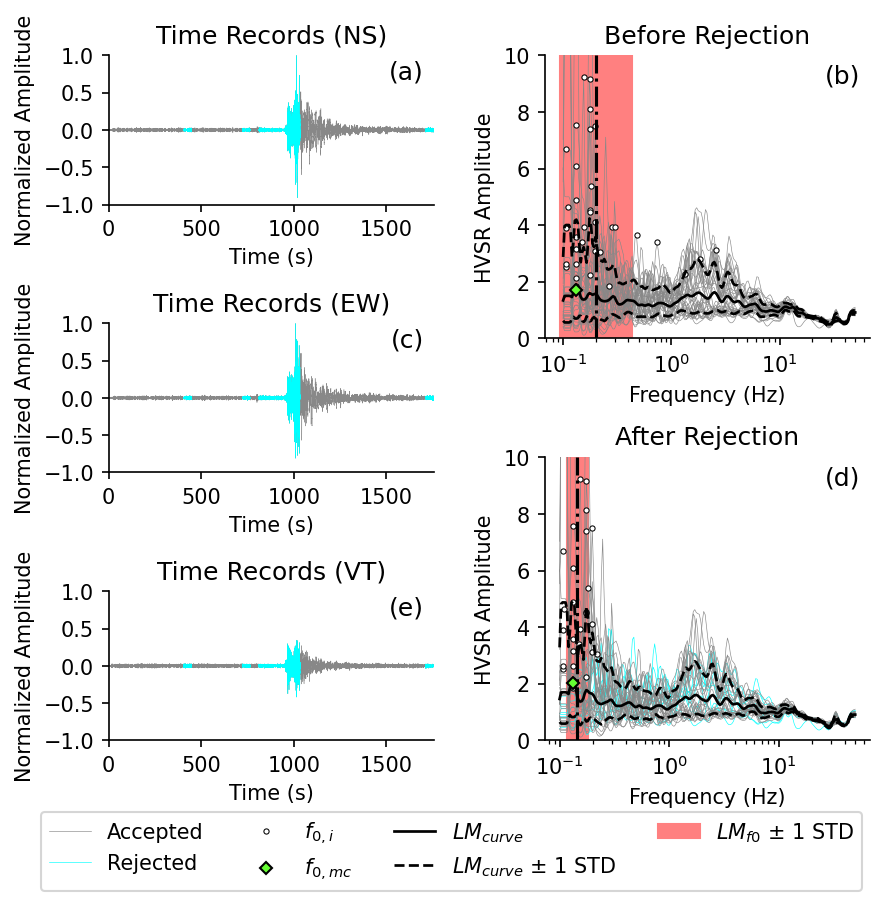

Elapsed Time: 0.13 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.20                          0.64
Fundamental Site Period, T0                 5.07                          0.64


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  4 of 50 allowed
No. of rejected windows                            6


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.16                          0.26
Fundamental Site Period, T0                 6.37                          0.26

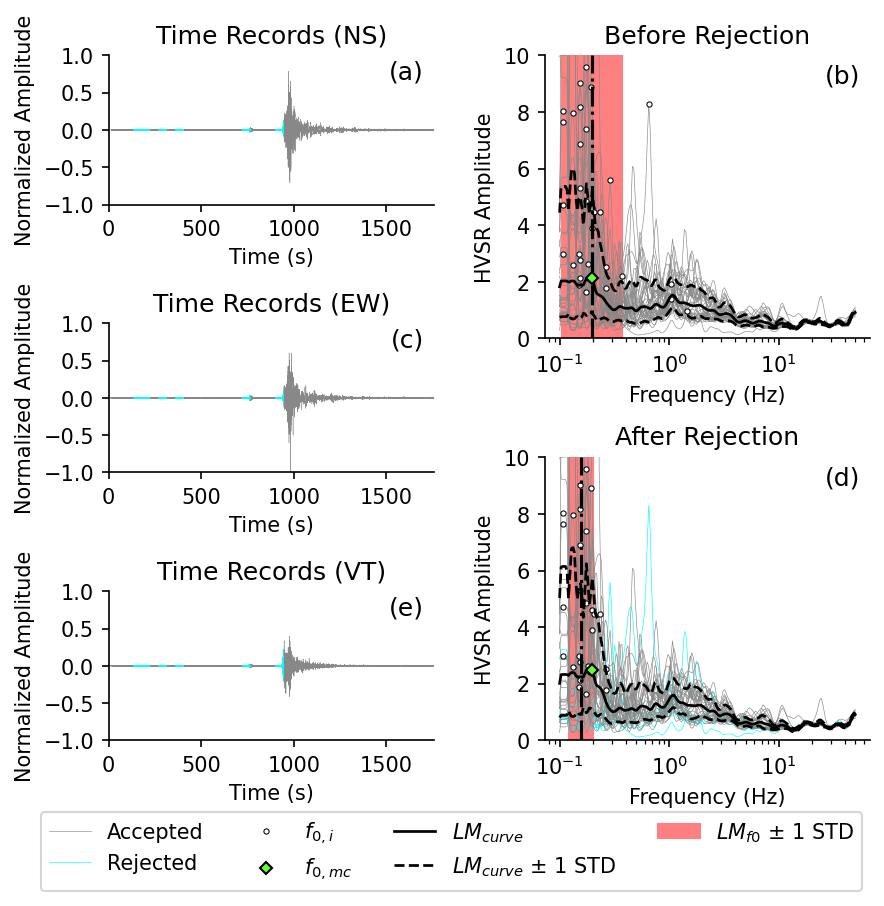

Elapsed Time: 0.12 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.38                          1.13
Fundamental Site Period, T0                 2.60                          1.13


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  3 of 50 allowed
No. of rejected windows                            2


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.34                          1.02
Fundamental Site Period, T0                 2.95                          1.02

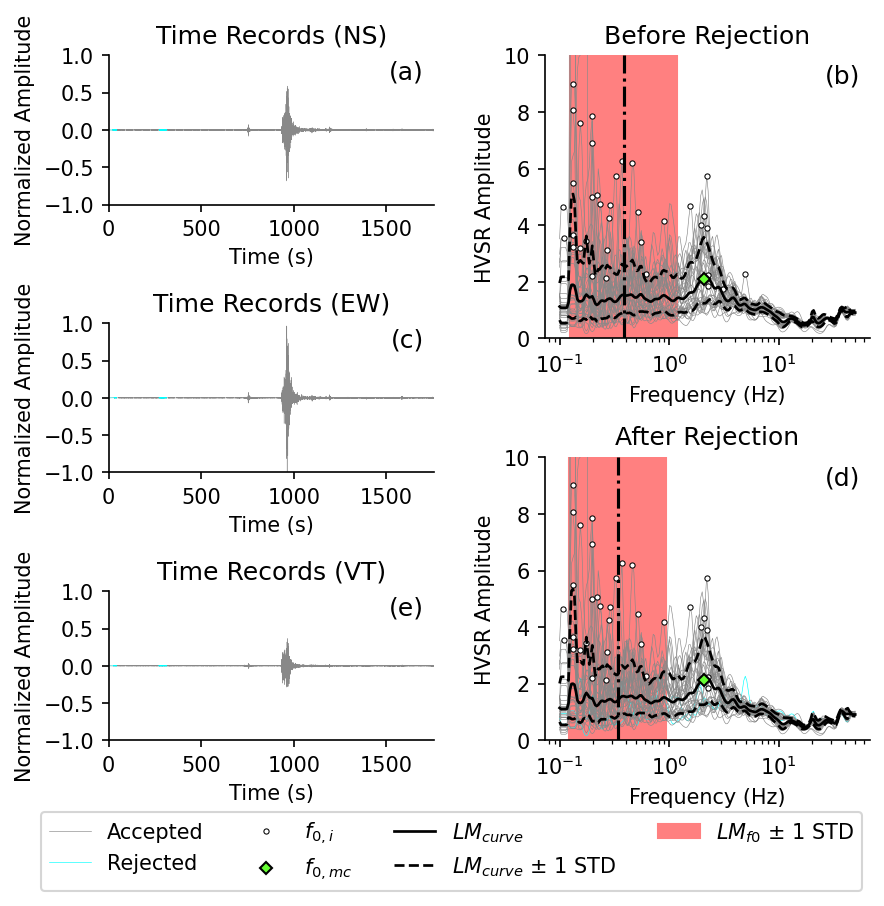

Elapsed Time: 0.10 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.35                          1.29
Fundamental Site Period, T0                 2.86                          1.29


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  5 of 50 allowed
No. of rejected windows                            7


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.22                          0.51
Fundamental Site Period, T0                 4.64                          0.51

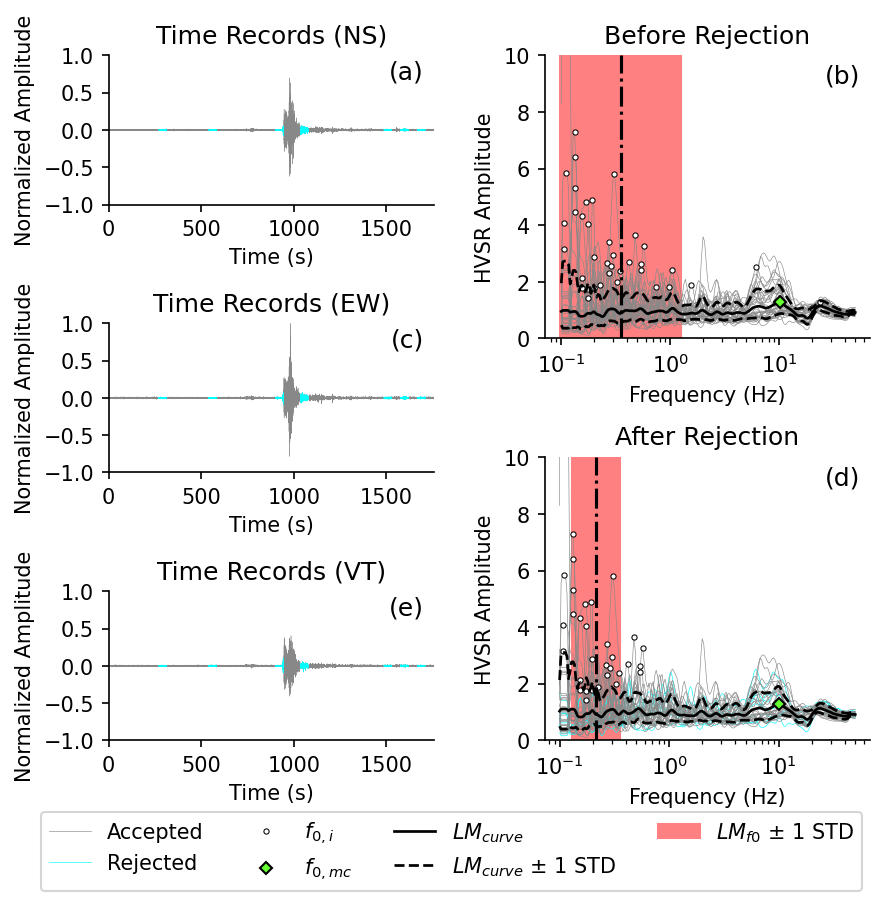

Elapsed Time: 0.10 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.33                          1.19
Fundamental Site Period, T0                 2.99                          1.19


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  5 of 50 allowed
No. of rejected windows                           10


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.18                          0.34
Fundamental Site Period, T0                 5.44                          0.34

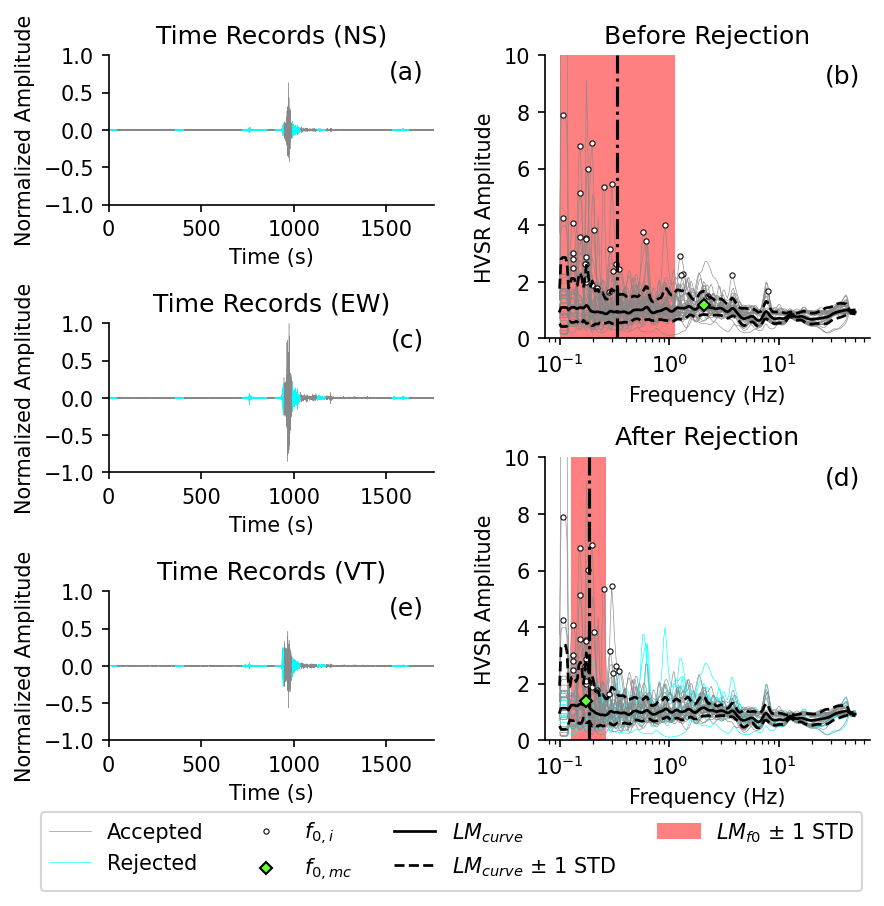

Elapsed Time: 0.10 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.42                          0.69
Fundamental Site Period, T0                 2.39                          0.69


Analysis summary:


Window length                                    45s
No. of windows                                    39
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              0.42                          0.69
Fundamental Site Period, T0                 2.39                          0.69

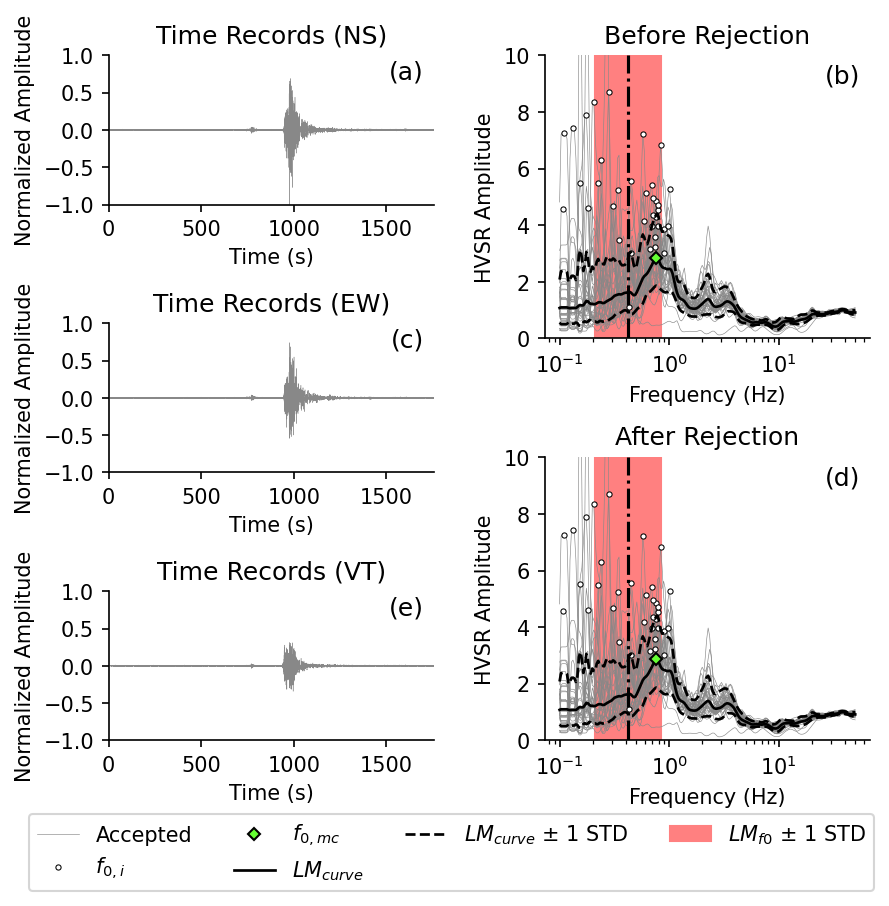

In [39]:
for file in sorted(files):   
    try:
        plot_list = get_hvsr(file)

    except:
        print(sys.exc_info())
        continue

In [23]:
plot_list = map(get_hvsr, files)

In [25]:
print(result)